In [3]:
import os
from unittest.mock import patch
import torch
from torch._dynamo import OptimizedModule
from torch.nn.parallel import DistributedDataParallel as DDP

def load_stunet_pretrained_weights(network, fname, verbose=False):
    """Load pretrained STU-Net weights"""
    saved_model = torch.load(fname)
    if fname.endswith('pth'):
        pretrained_dict = saved_model['network_weights']
    elif fname.endswith('model'):
        pretrained_dict = saved_model['state_dict']
    
    skip_strings_in_pretrained = ['seg_outputs']
    
    if isinstance(network, DDP):
        mod = network.module
    else:
        mod = network
        
    if isinstance(mod, OptimizedModule):
        mod = mod._orig_mod
        
    model_dict = mod.state_dict()
    
    pretrained_dict = {k: v for k, v in pretrained_dict.items()
                      if k in model_dict.keys() and all([i not in k for i in skip_strings_in_pretrained])}
    
    model_dict.update(pretrained_dict)
    
    if verbose:
        print("\nLoading pretrained weights from", fname)
        print("Matching blocks being loaded:")
        for key, value in pretrained_dict.items():
            print(f"{key}: {value.shape}")
    
    mod.load_state_dict(model_dict, strict=False)
    return mod

def main():
    # Set paths
    base_dir = "/vast/palmer/home.grace/am3833/fly/segmentation"
    os.environ['nnUNet_raw'] = os.path.join(base_dir, "nnUNet_raw")
    os.environ['nnUNet_preprocessed'] = os.path.join(base_dir, "nnUNet_preprocessed")
    os.environ['nnUNet_results'] = os.path.join(base_dir, "nnUNet_results")

    print("Starting finetuning...")
    import sys
    sys.argv = [
        'ignored',
        'Dataset001_Microtubules',  # Dataset name
        '3d_fullres',  # Configuration
        '0',  # Fold
        '-tr', 'STUNetTrainer_base_ft',  # Trainer class
        '-pretrained_weights', 'pretrained/small_ep4k.model',  # Pretrained weights path
        '-gpu_memory_target', '8',  # GPU memory target in GB
    ]
    
    # Use STU-Net weight loading function
    with patch("nnunetv2.run.run_training.load_pretrained_weights", load_stunet_pretrained_weights):
        from nnunetv2.run.run_training import run_training_entry
        run_training_entry()

if __name__ == "__main__":
    main()

Starting finetuning...


usage: ignored [-h] [-tr TR] [-p P] [-pretrained_weights PRETRAINED_WEIGHTS]
               [-num_gpus NUM_GPUS] [--use_compressed] [--npz] [--c] [--val]
               [--val_best] [--disable_checkpointing] [-device DEVICE]
               dataset_name_or_id configuration fold
ignored: error: unrecognized arguments: -gpu_memory_target 8


SystemExit: 2

/home/am3833/jupyterlab_venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
import os
import sys

# Set paths
os.environ['nnUNet_raw'] = "/vast/palmer/home.grace/am3833/fly/segmentation/nnUNet_raw"
os.environ['nnUNet_preprocessed'] = "/vast/palmer/home.grace/am3833/fly/segmentation/nnUNet_preprocessed"
os.environ['nnUNet_results'] = "/vast/palmer/home.grace/am3833/fly/segmentation/nnUNet_results"

# Make sure directories exist
os.makedirs(os.environ['nnUNet_preprocessed'], exist_ok=True)
os.makedirs(os.environ['nnUNet_results'], exist_ok=True)

print("Running preprocessing...")

sys.argv = [
    '',
    '-d', '1',
    '-c', '3d_fullres',
    '-np', '8'
]

from nnunetv2.experiment_planning.plan_and_preprocess_entrypoints import plan_and_preprocess_entry
plan_and_preprocess_entry()

Running preprocessing...
Fingerprint extraction...
Dataset001_Microtubules
Experiment planning...
2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 214, 'patch_size': array([112,   1]), 'median_image_size_in_voxels': array([100.,   1.]), 'spacing': array([1., 1.]), 'normalization_schemes': ['ZScoreNormalization'], 'use_mask_for_norm': [False], 'UNet_class_name': 'PlainConvUNet', 'UNet_base_num_features': 32, 'n_conv_per_stage_encoder': (2, 2, 2, 2, 2), 'n_conv_per_stage_decoder': (2, 2, 2, 2), 'num_pool_per_axis': [4, 0], 'pool_op_kernel_sizes': [[1, 1], [2, 1], [2, 1], [2, 1], [2, 1]], 'conv_kernel_sizes': [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]], 'unet_max_num_features': 512, 'resampling_fn_data': 'resample_data_or_seg_to_shape', 'resampling_fn_seg': 'resample_data_or_seg_to_shape', 'resampling_fn_data_kwargs': {'is_seg': False, 'order': 3, 'order_z': 0, 'force_separate_z': None}, 'resampling_fn_seg_kwargs': {'is_s

100%|██████████| 48/48 [00:04<00:00, 10.08it/s]


In [3]:
import os
import nibabel as nib
import numpy as np

# Paths to your images and labels directories
images_dir = 'nnUNet_raw/Dataset001_Microtubules/imagesTr'
labels_dir = 'nnUNet_raw/Dataset001_Microtubules/labelsTr'

# Function to process files in a directory
def process_nifti_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.nii.gz'):
            file_path = os.path.join(directory, filename)
            # Load the NIfTI file
            nifti_img = nib.load(file_path)
            data = nifti_img.get_fdata()
            original_shape = data.shape
            # Remove singleton dimensions
            new_data = np.squeeze(data)
            new_shape = new_data.shape
            if original_shape != new_shape:
                print(f'Processing {filename}: original shape {original_shape}, new shape {new_shape}')
                # Save the modified data back to the same file
                new_nifti = nib.Nifti1Image(new_data, affine=nifti_img.affine, header=nifti_img.header)
                nib.save(new_nifti, file_path)
            else:
                print(f'{filename}: no singleton dimension to remove, shape remains {new_shape}')

# Process images and labels
print('Processing images...')
process_nifti_files(images_dir)

print('\nProcessing labels...')
process_nifti_files(labels_dir)

print('\nAll files have been processed.')


Processing images...
Processing 000_0000.nii.gz: original shape (1, 100, 100, 100), new shape (100, 100, 100)
Processing 001_0000.nii.gz: original shape (1, 100, 100, 100), new shape (100, 100, 100)
Processing 002_0000.nii.gz: original shape (1, 100, 100, 100), new shape (100, 100, 100)
Processing 003_0000.nii.gz: original shape (1, 100, 100, 100), new shape (100, 100, 100)
Processing 004_0000.nii.gz: original shape (1, 100, 100, 100), new shape (100, 100, 100)
Processing 005_0000.nii.gz: original shape (1, 100, 100, 100), new shape (100, 100, 100)
Processing 006_0000.nii.gz: original shape (1, 100, 100, 100), new shape (100, 100, 100)
Processing 007_0000.nii.gz: original shape (1, 100, 100, 100), new shape (100, 100, 100)
Processing 008_0000.nii.gz: original shape (1, 100, 100, 100), new shape (100, 100, 100)
Processing 009_0000.nii.gz: original shape (1, 100, 100, 100), new shape (100, 100, 100)
Processing 010_0000.nii.gz: original shape (1, 100, 100, 100), new shape (100, 100, 100)


Found 11 validation cases: ['002', '008', '012', '020', '021', '028', '031', '032', '035', '040', 'summary']

Case: 002

Slice 25:
Image shape: (100, 100, 100)
Image value range: [0.00, 0.98]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.704


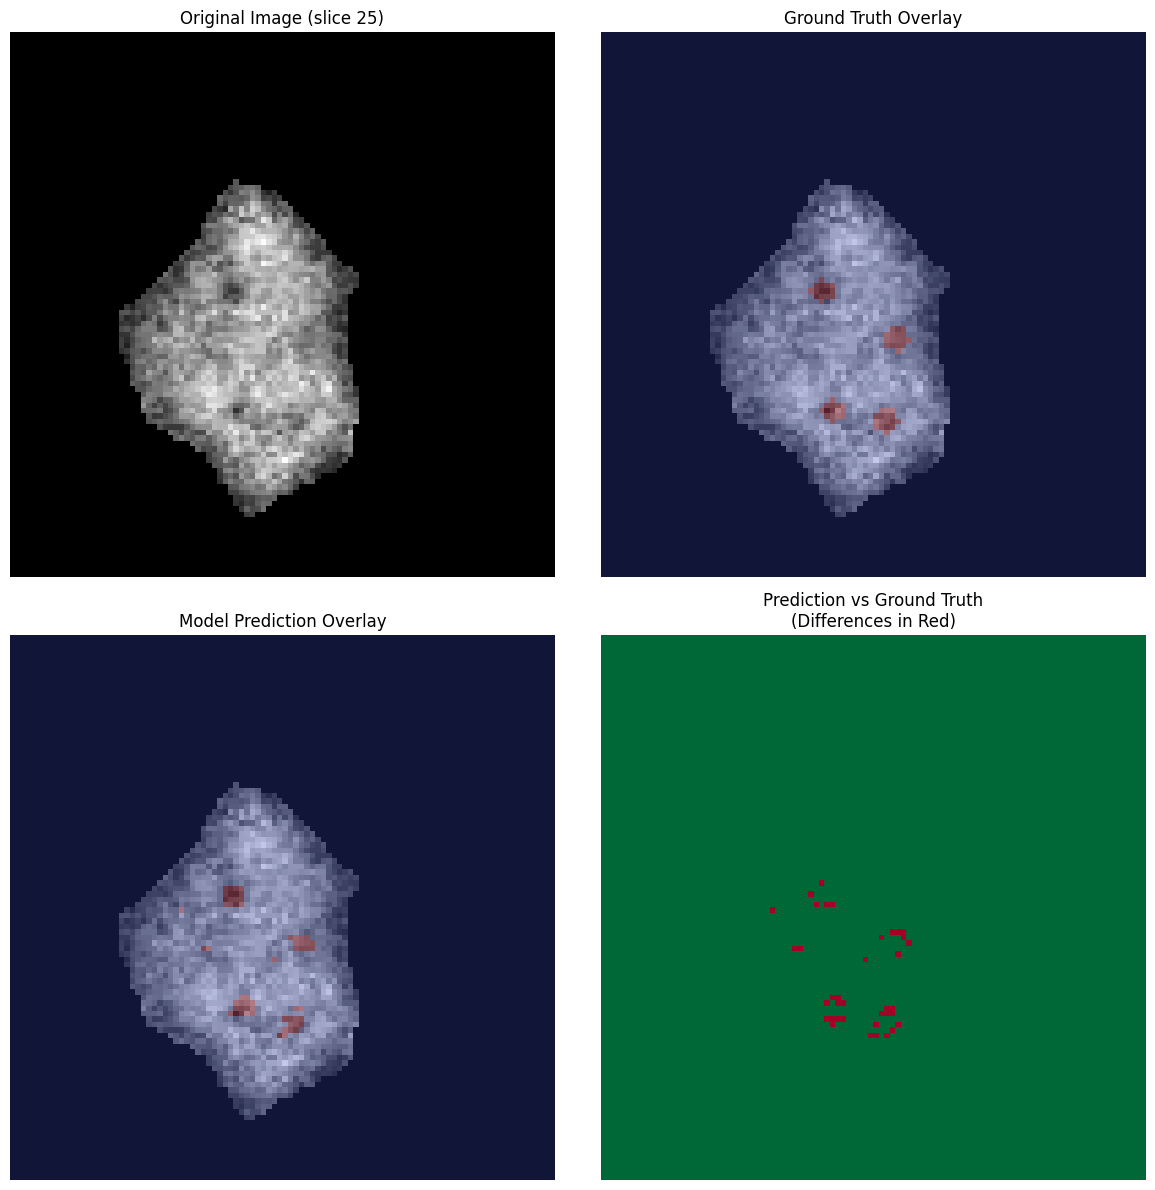


Slice 50:
Image shape: (100, 100, 100)
Image value range: [0.00, 0.98]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.645


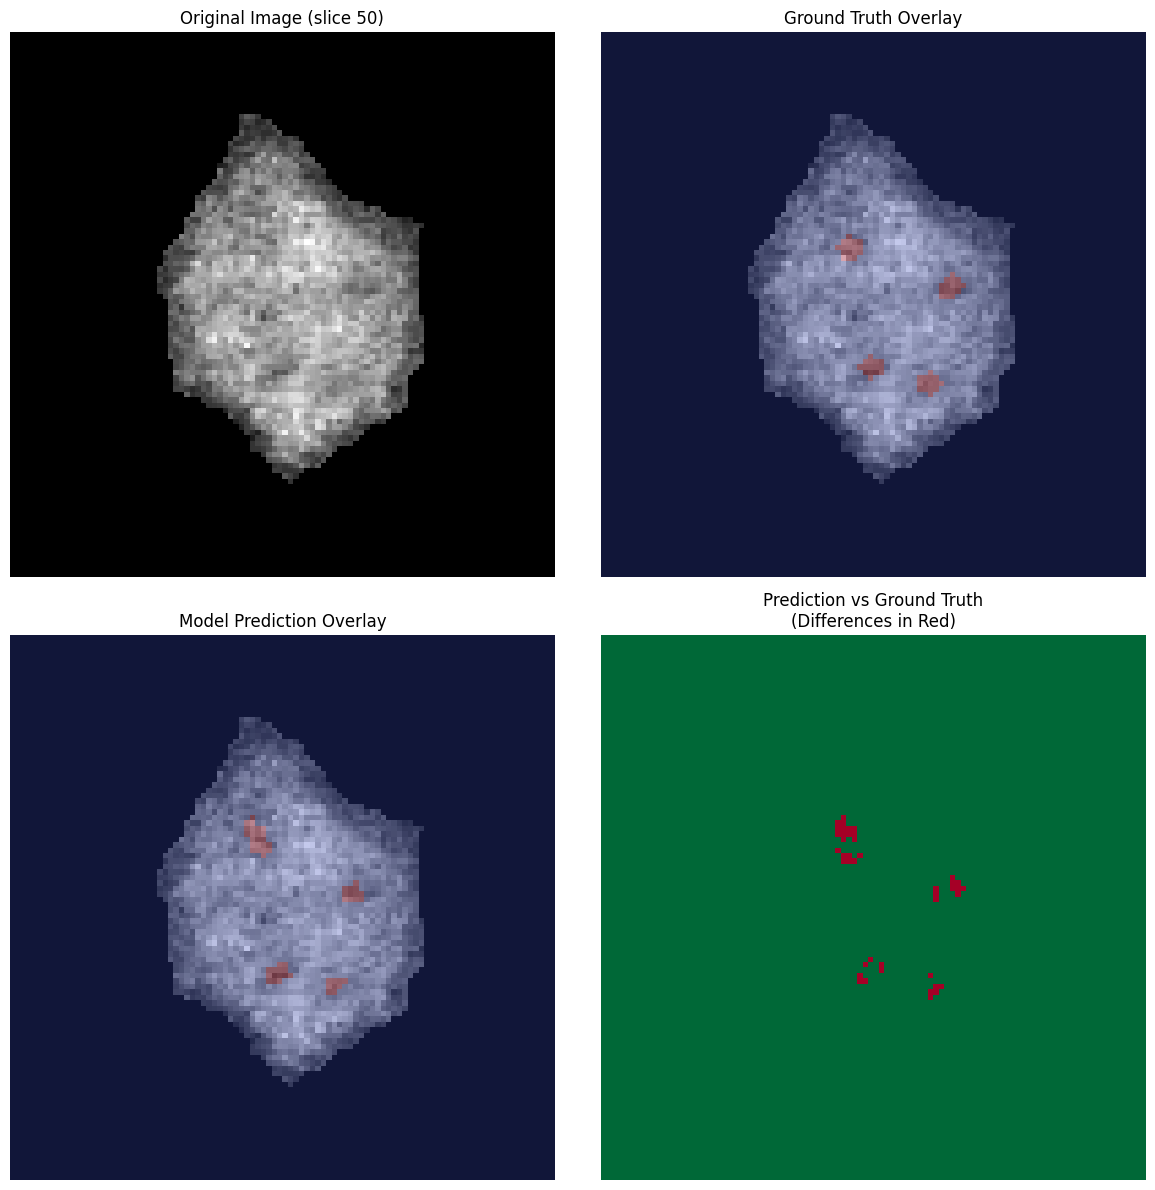


Slice 75:
Image shape: (100, 100, 100)
Image value range: [0.00, 0.98]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.748


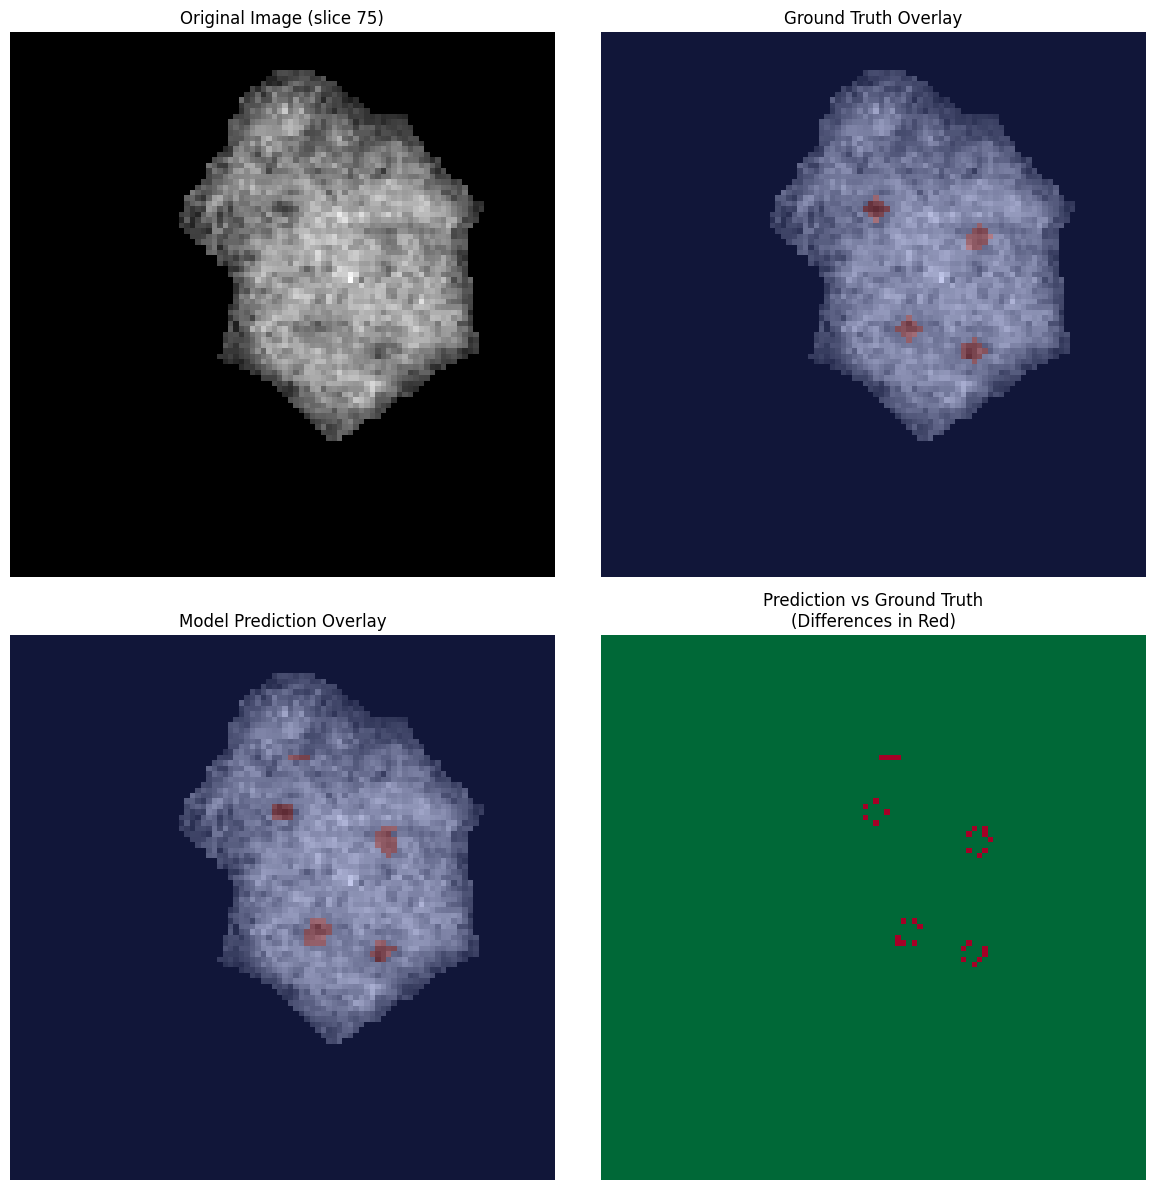


Case: 008

Slice 25:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.604


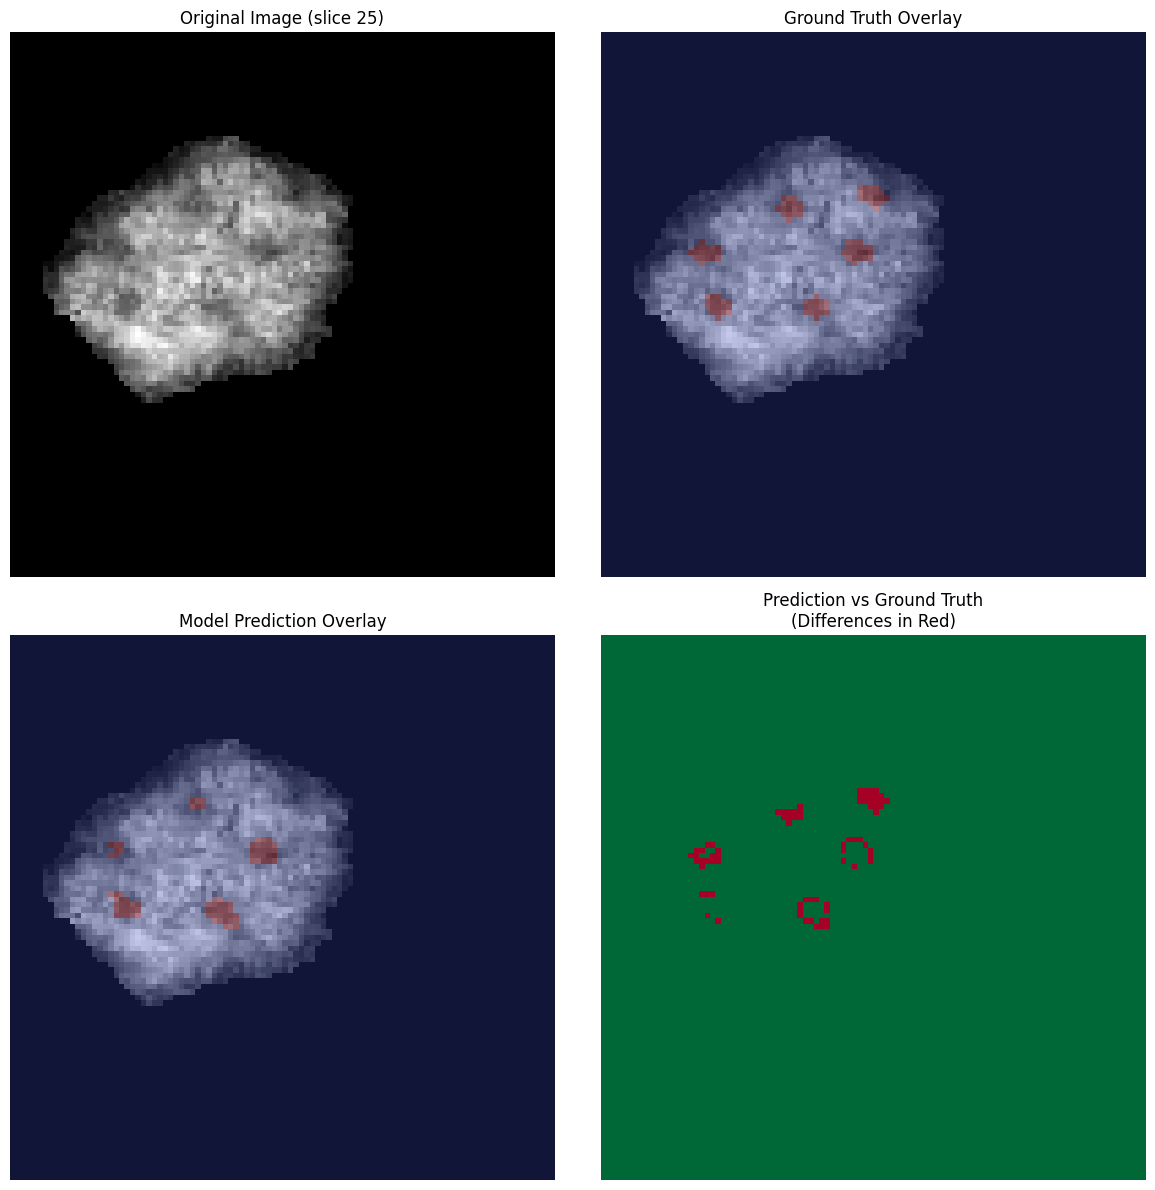


Slice 50:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.571


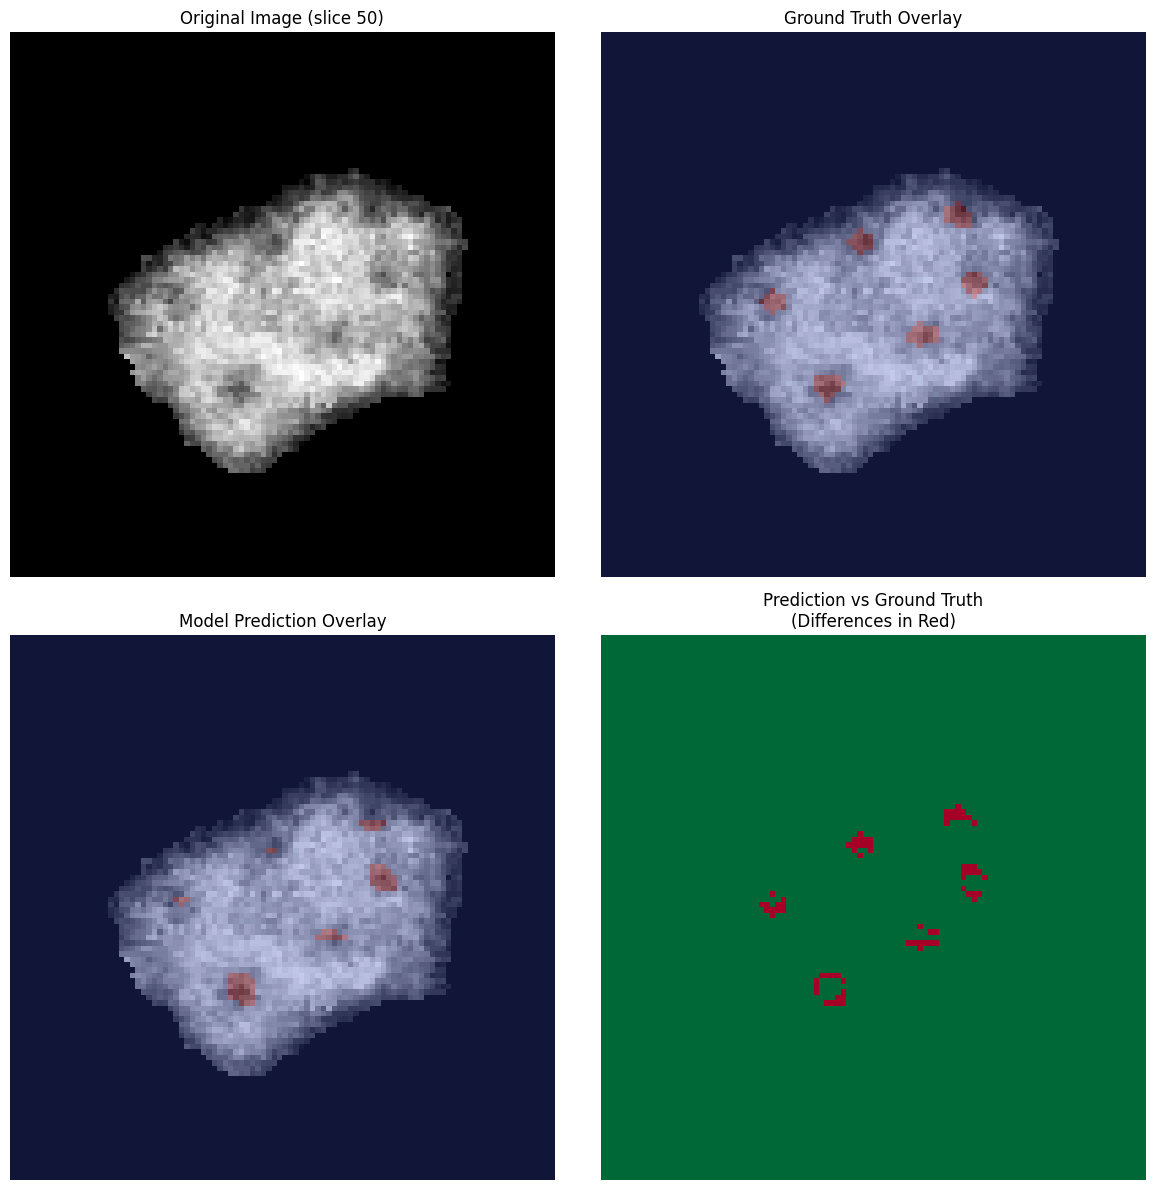


Slice 75:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.638


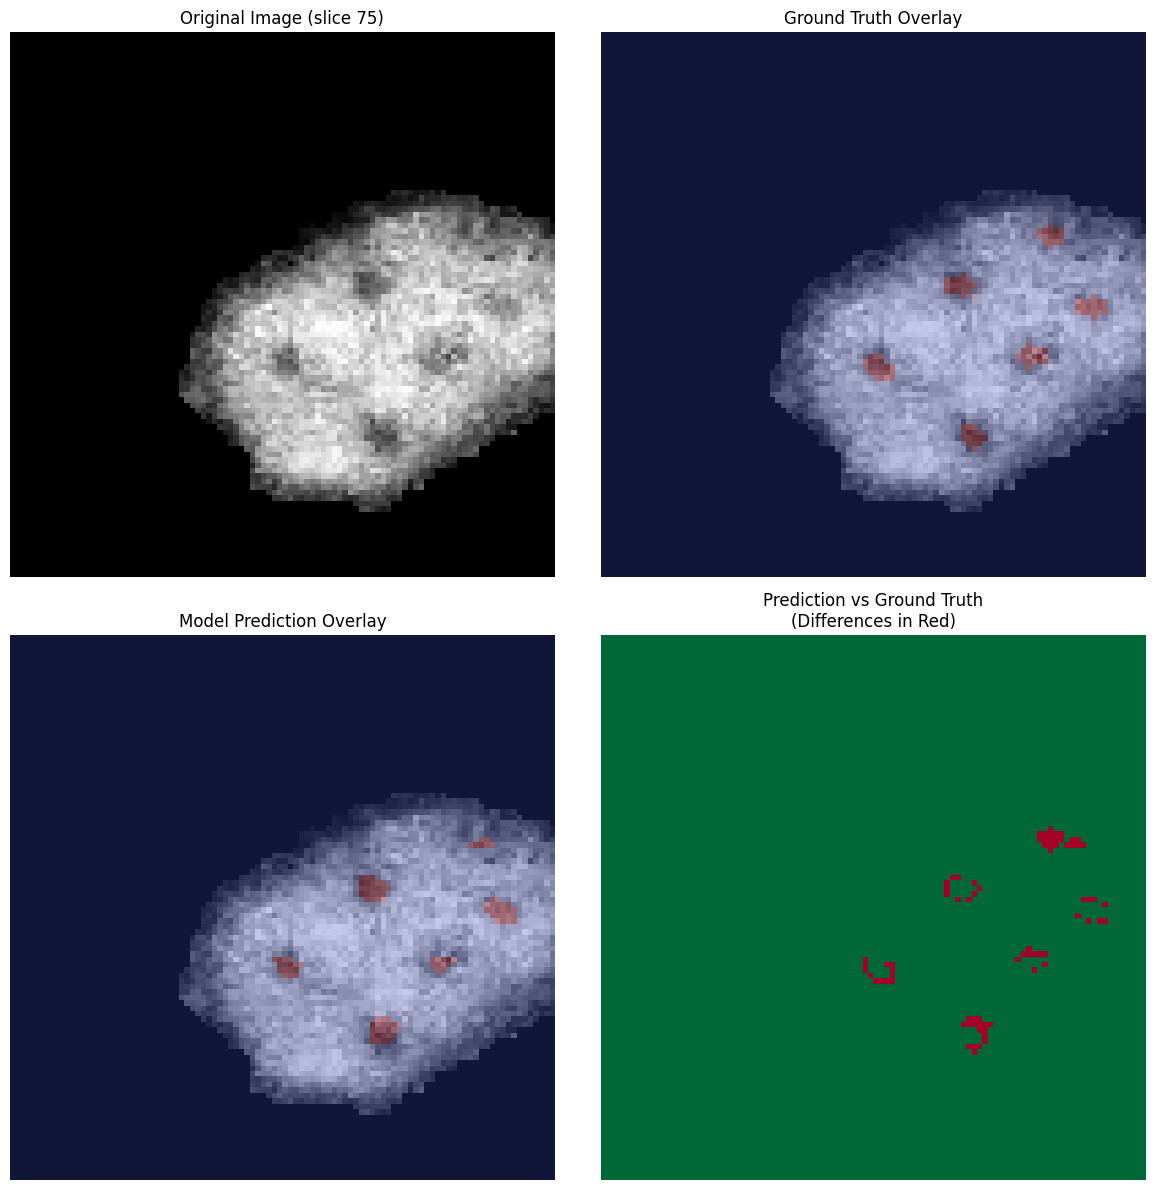


Case: 012

Slice 25:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.505


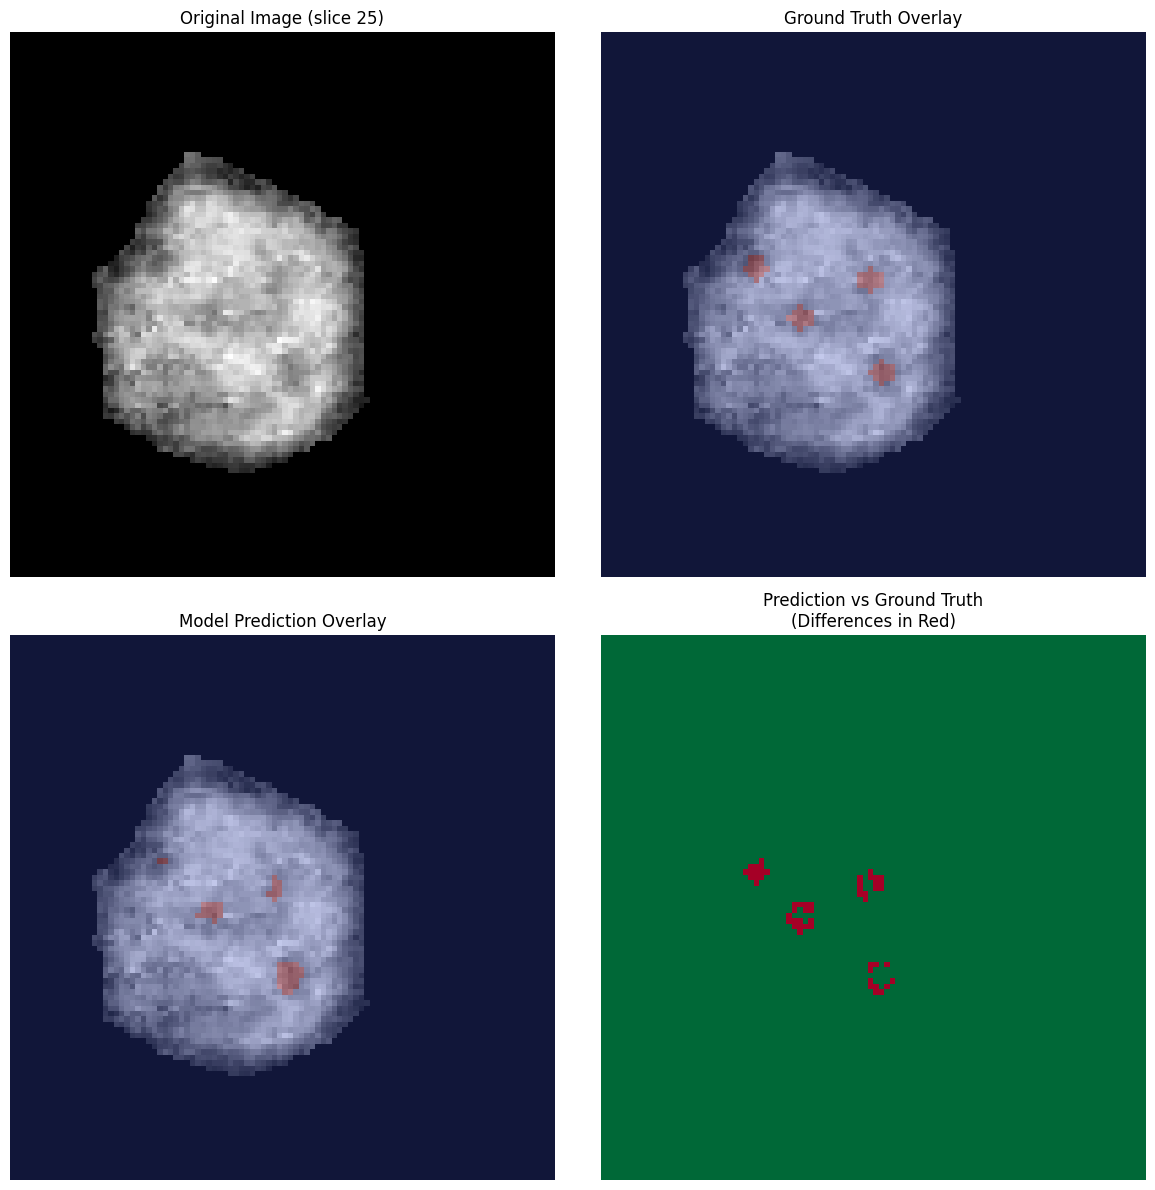


Slice 50:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.494


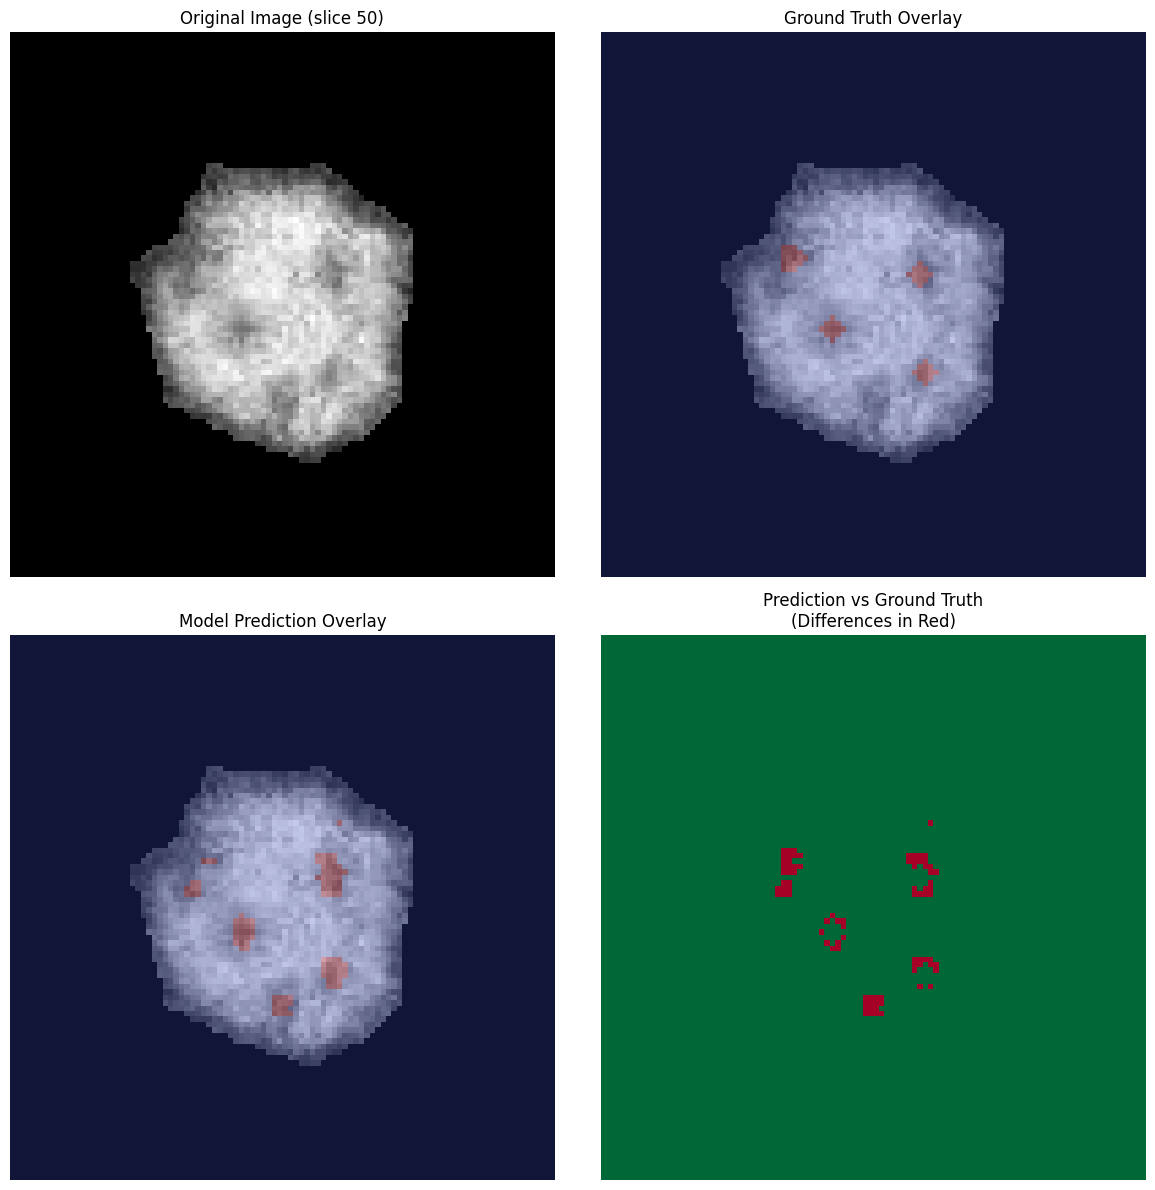


Slice 75:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.500


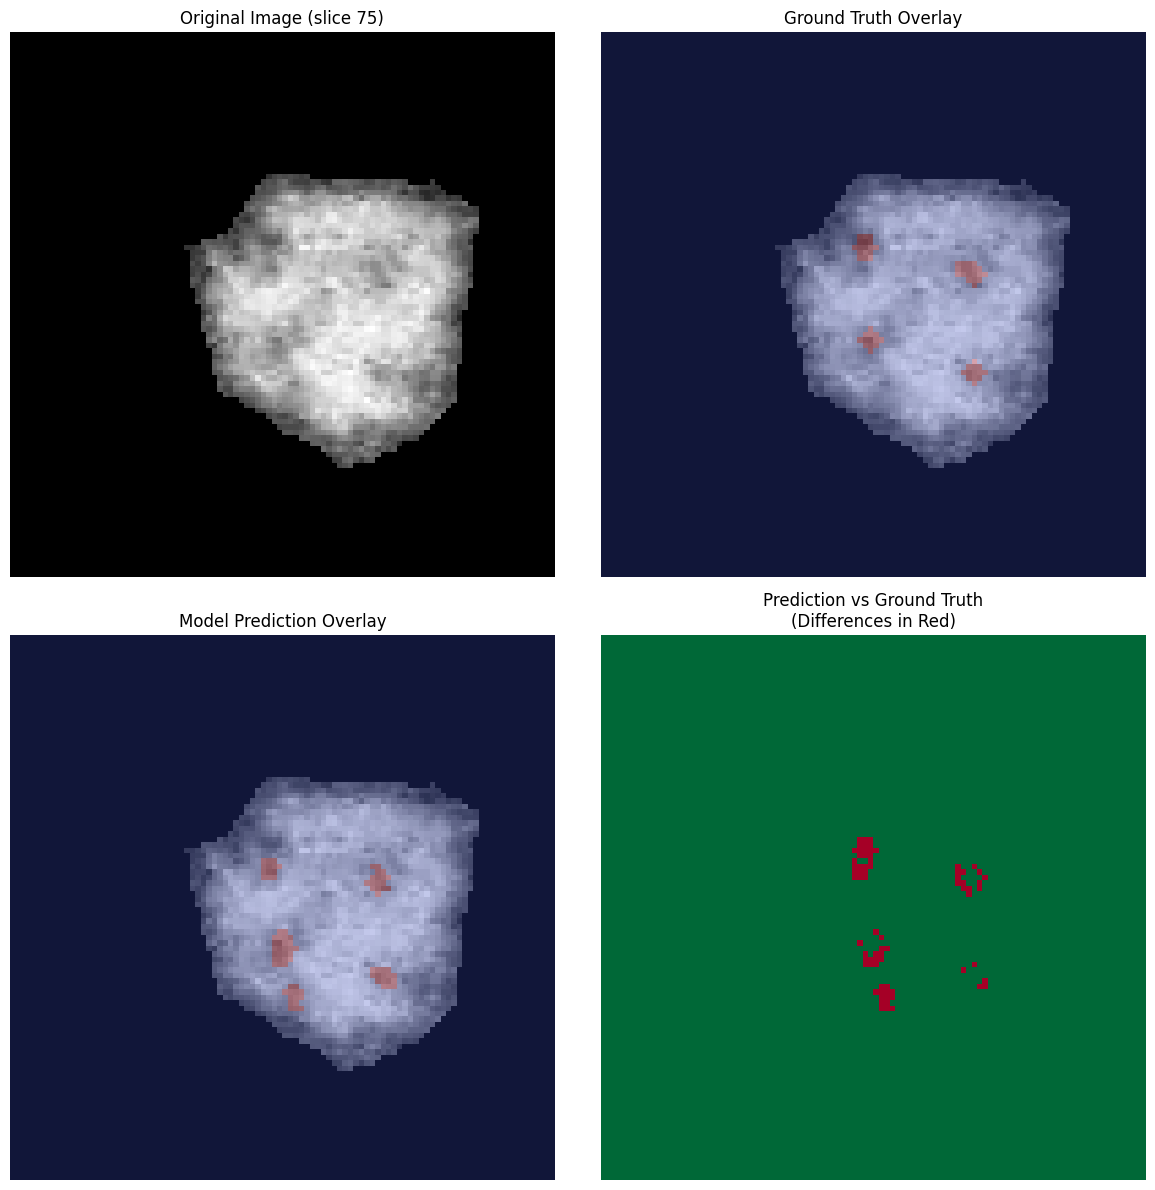


Case: 020

Slice 25:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.419


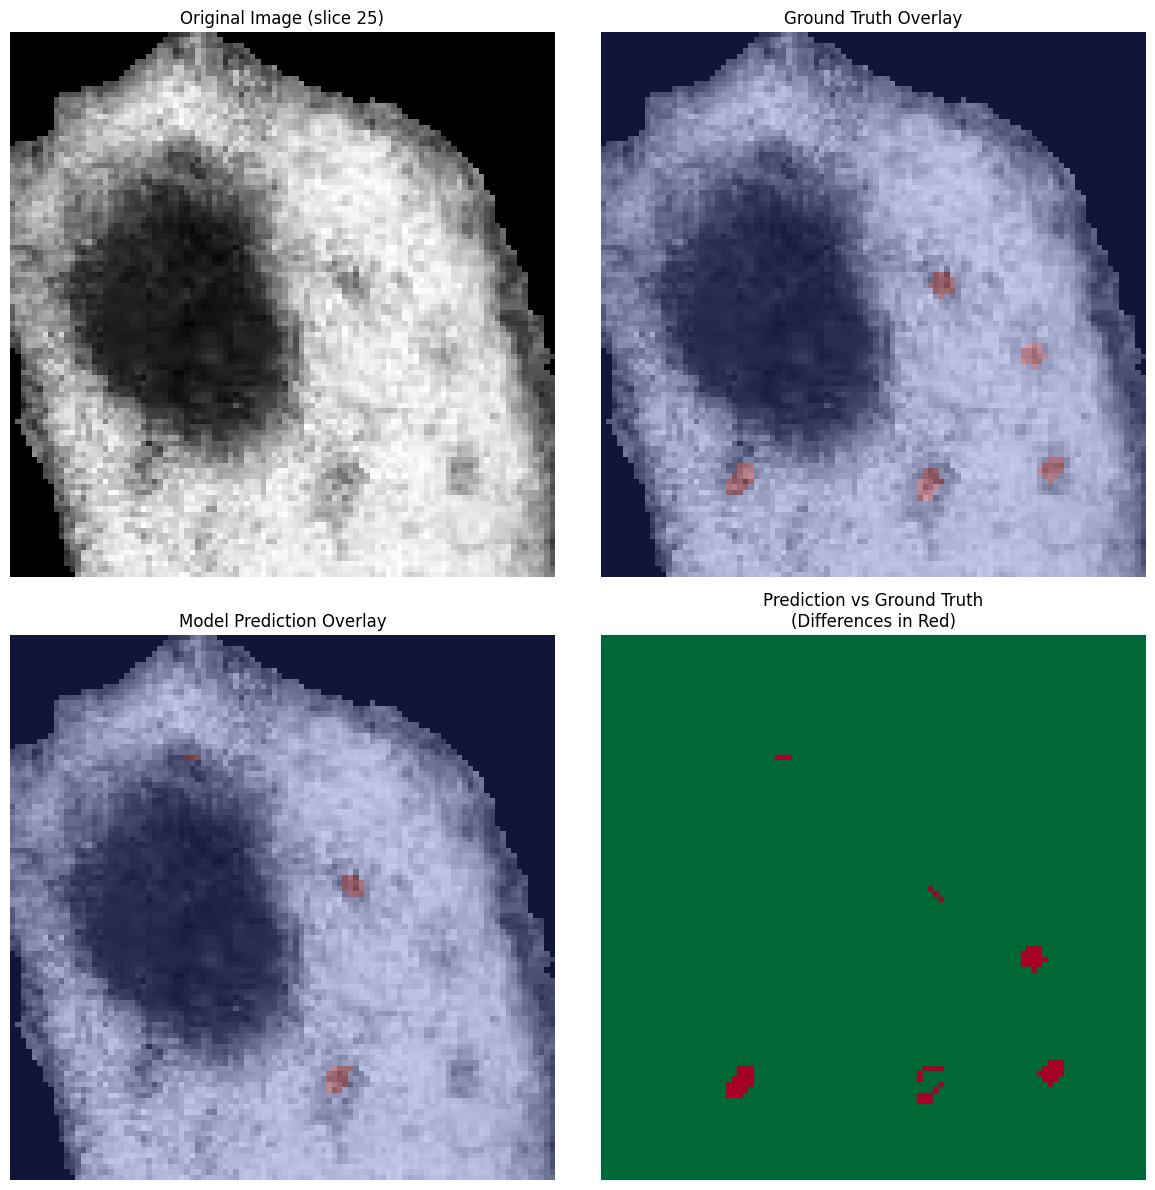


Slice 50:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.473


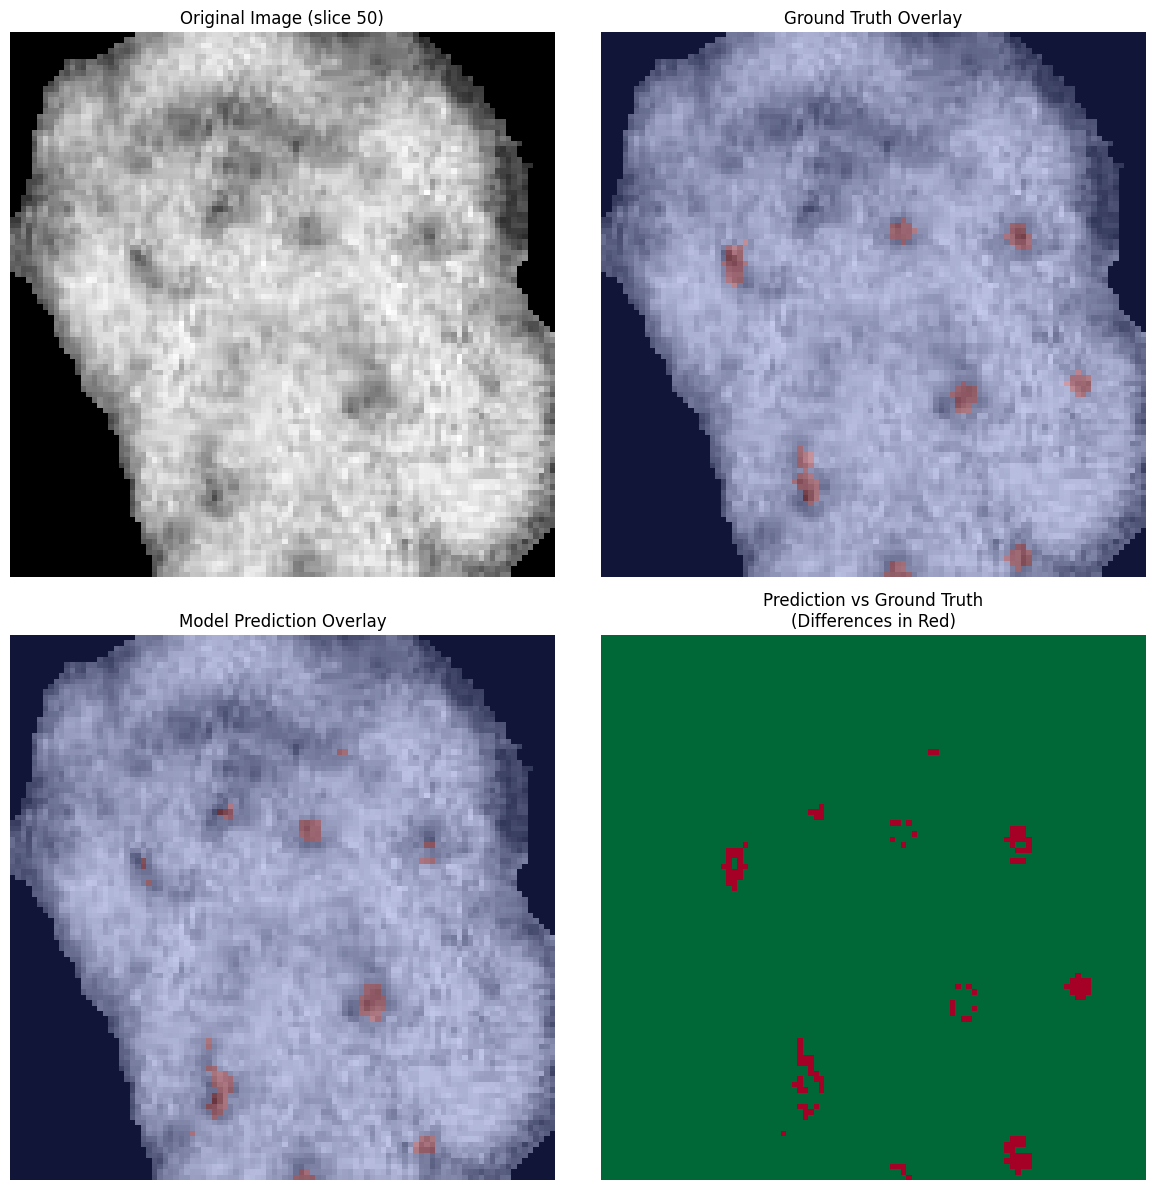


Slice 75:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.432


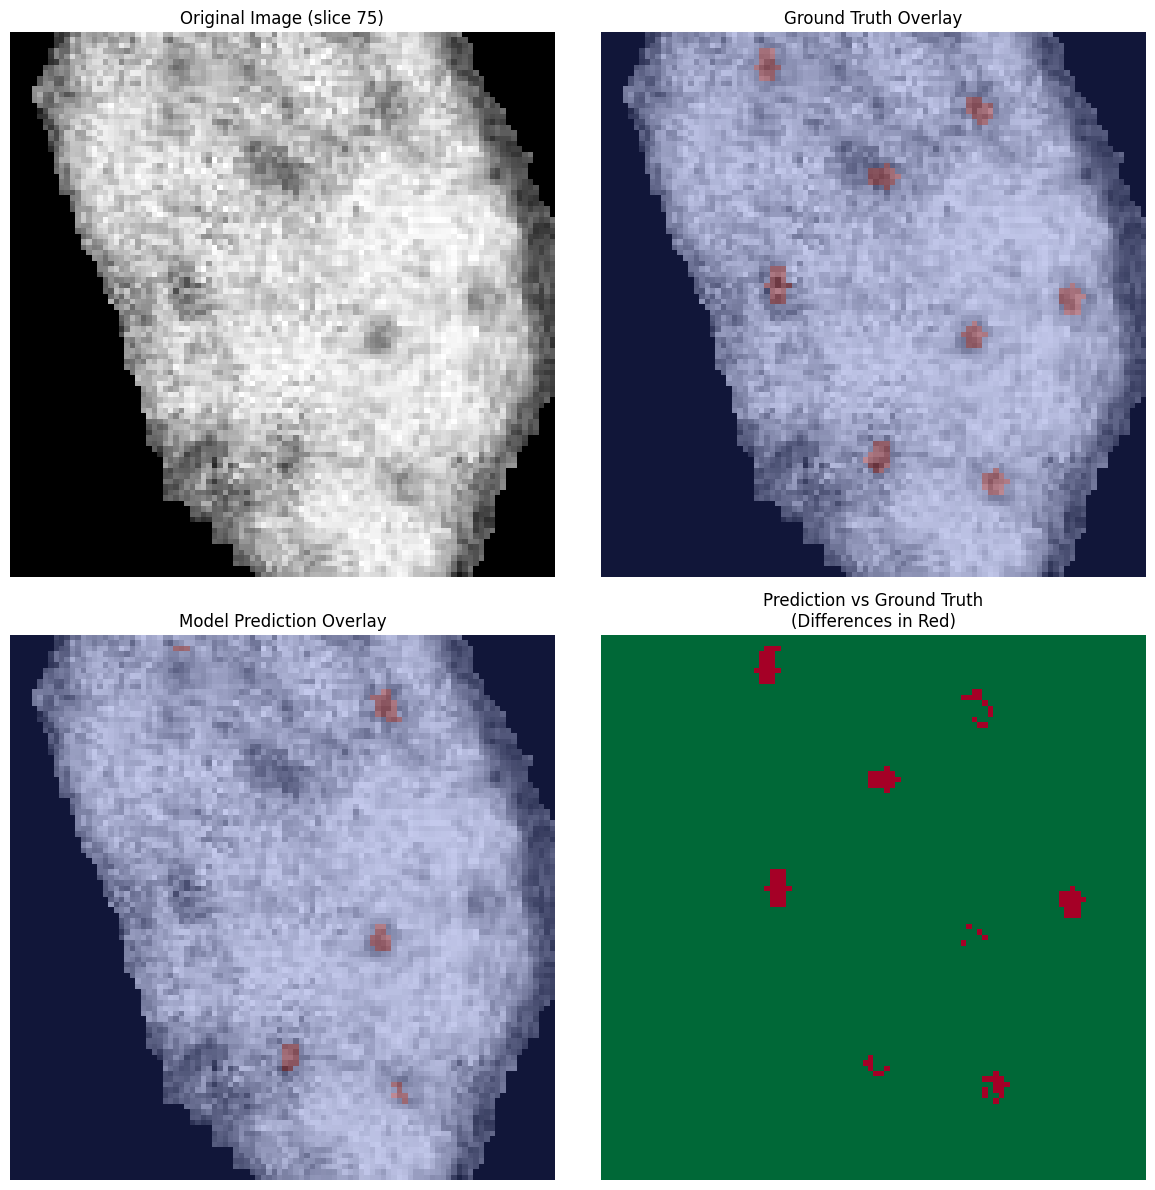


Case: 021

Slice 25:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.654


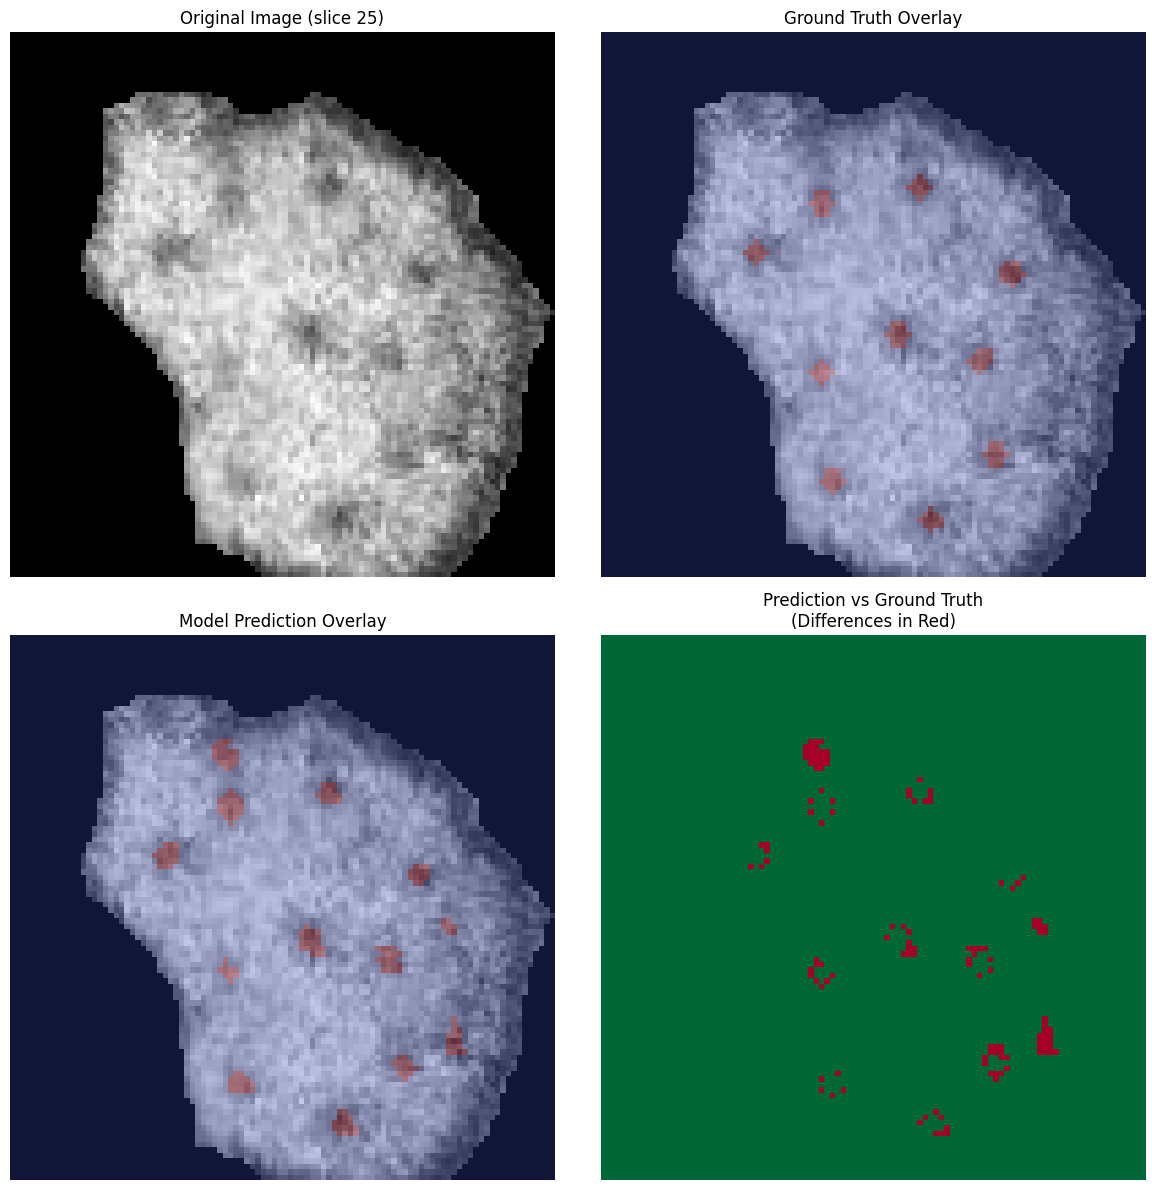


Slice 50:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.705


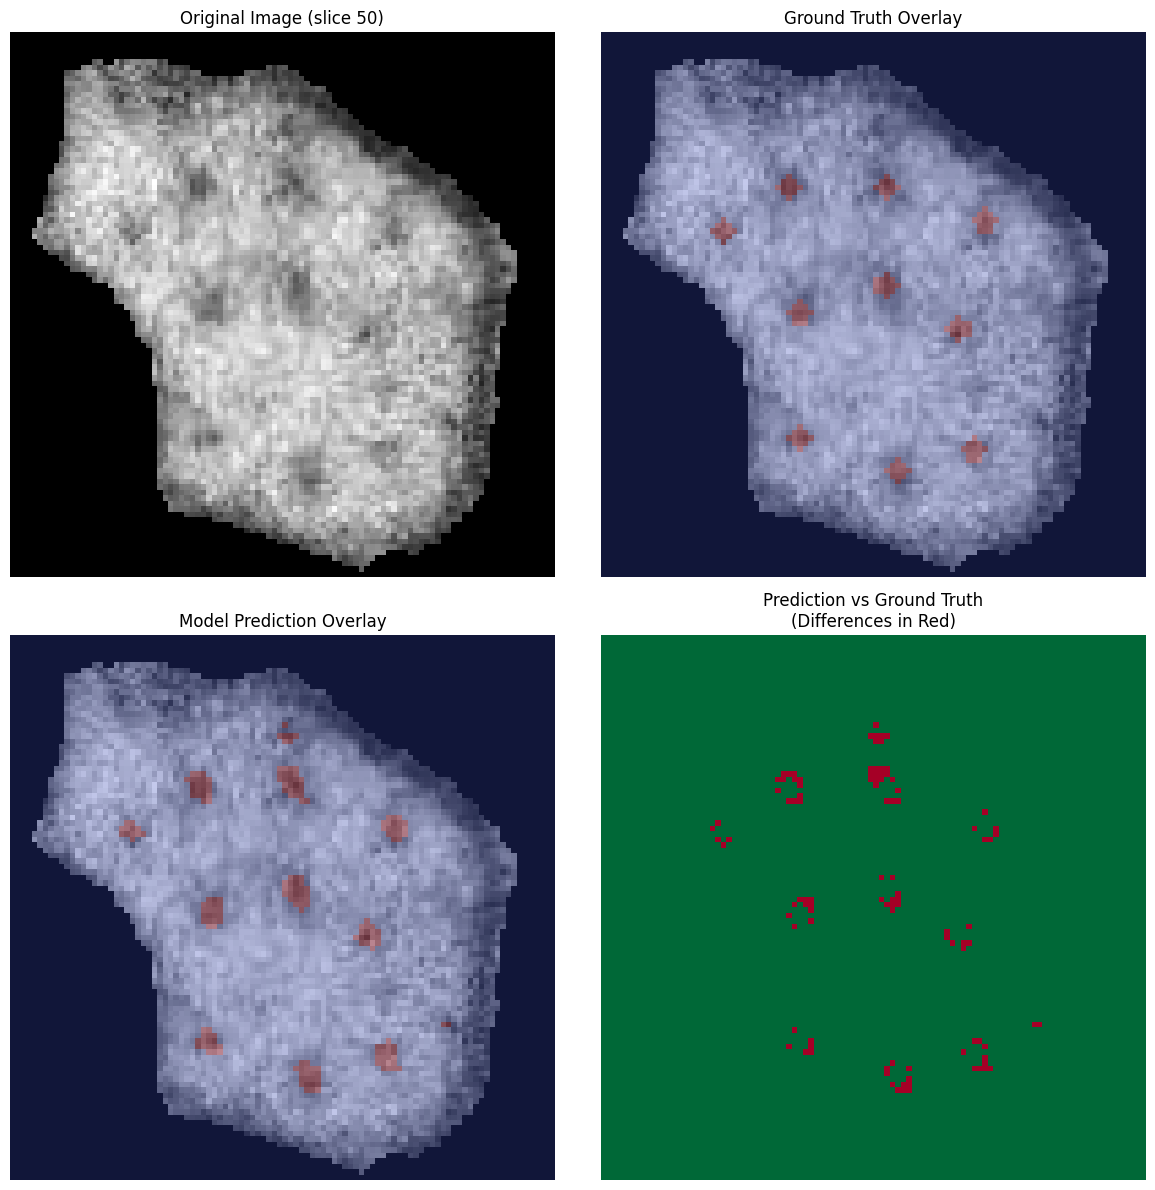


Slice 75:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.693


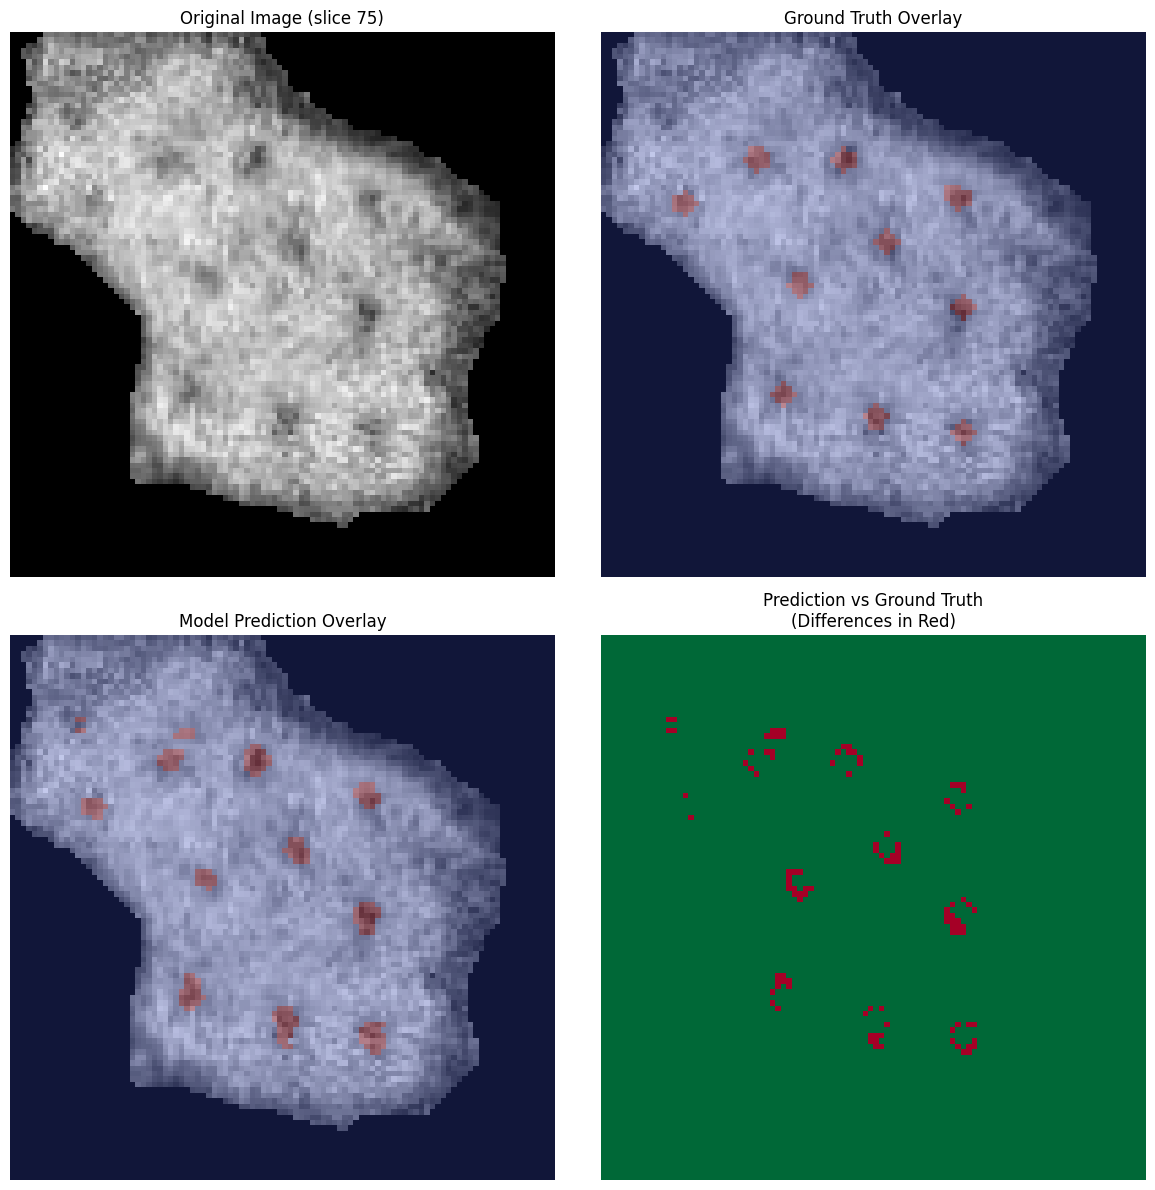


Case: 028

Slice 25:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.690


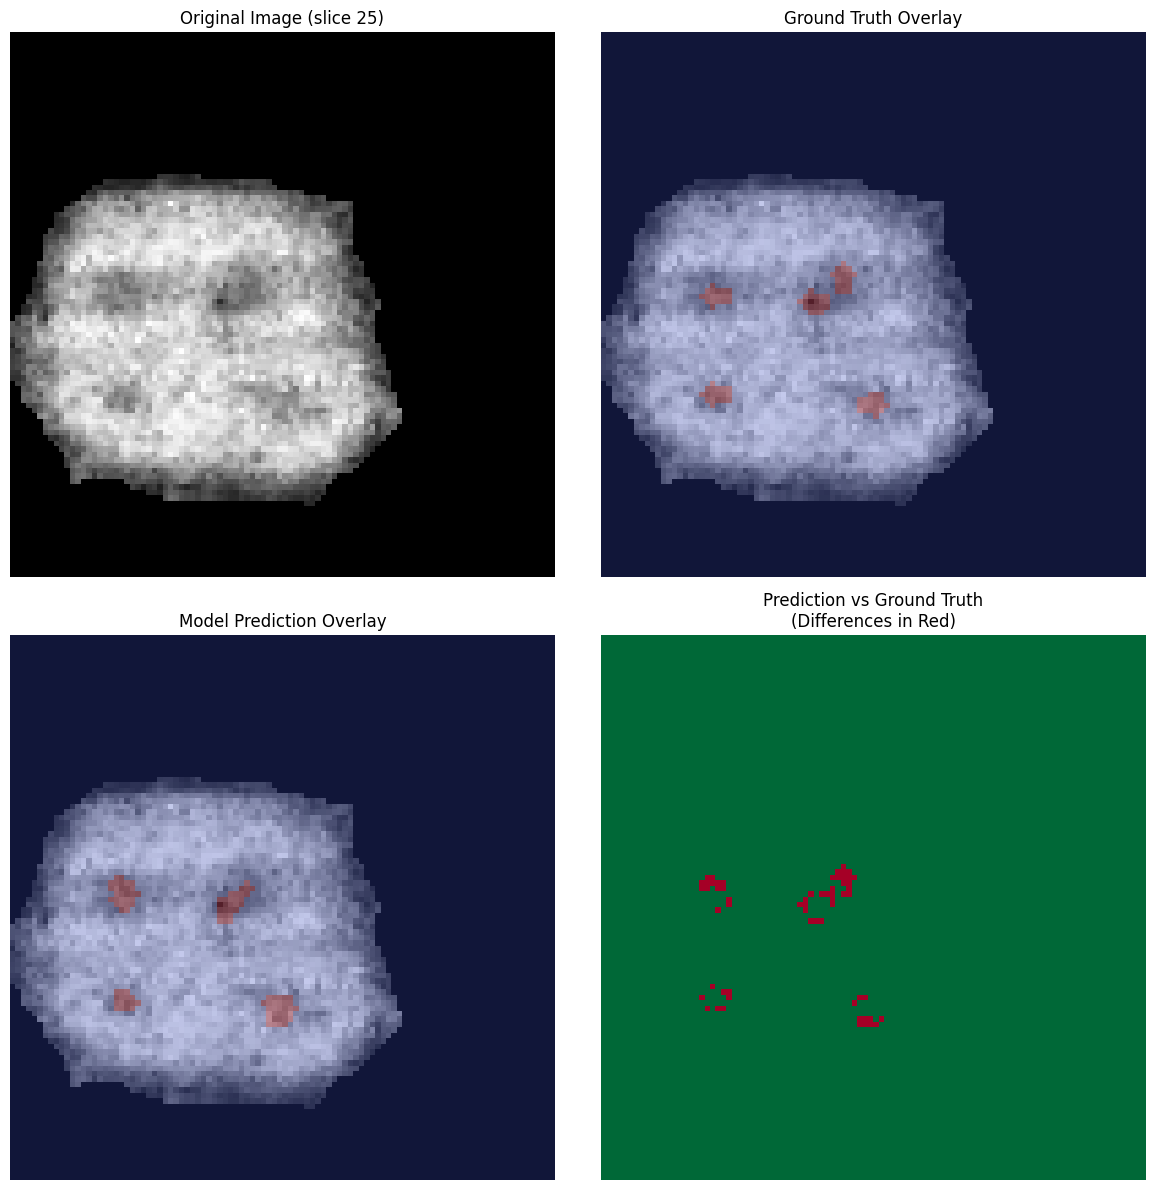


Slice 50:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.684


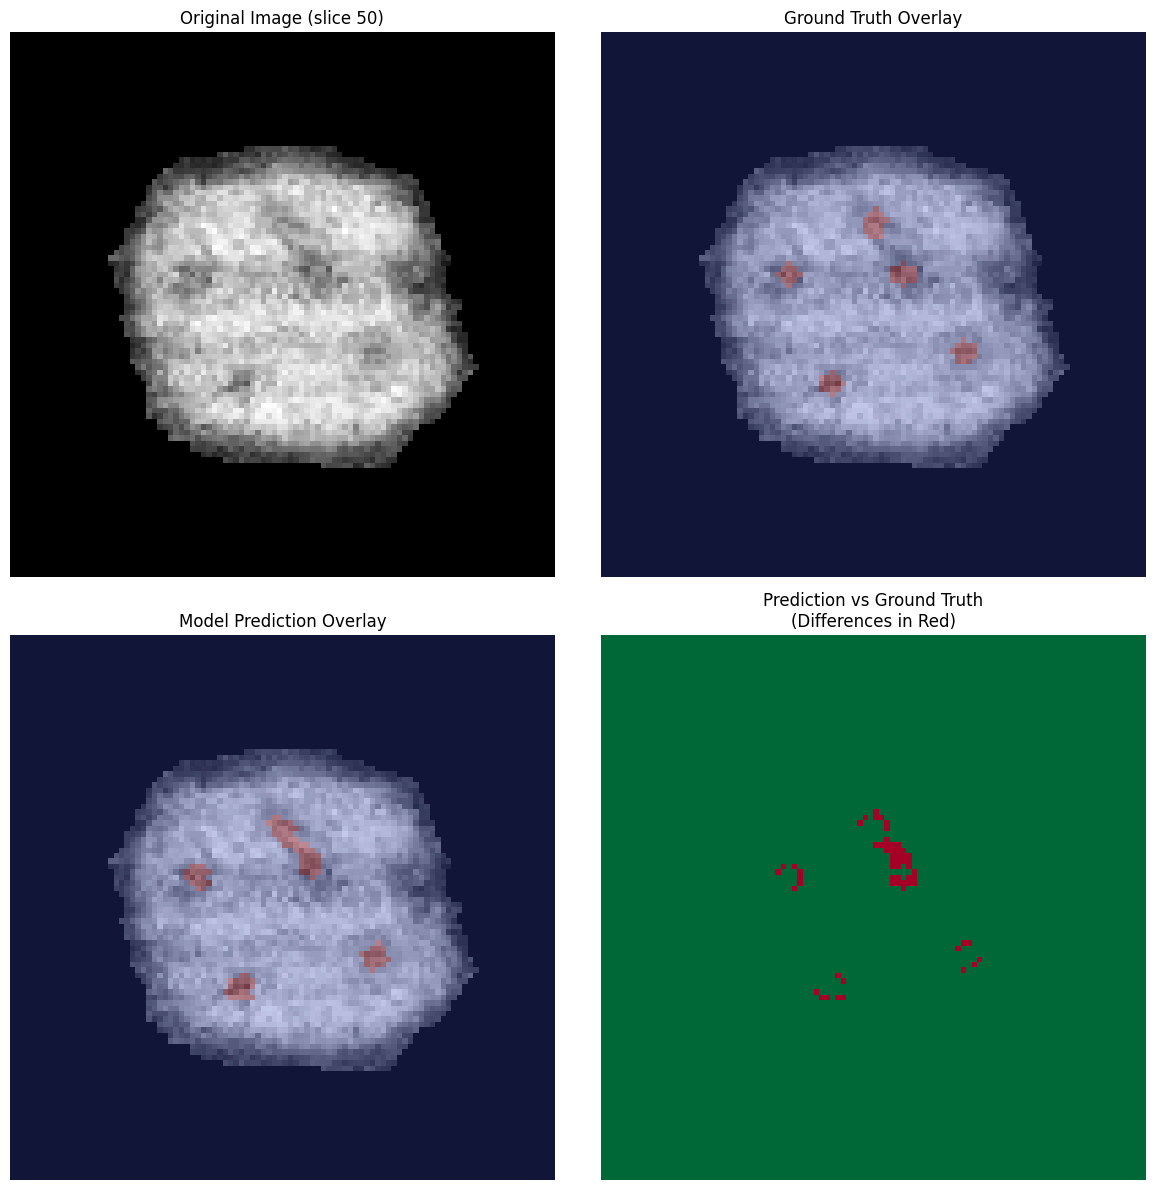


Slice 75:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.659


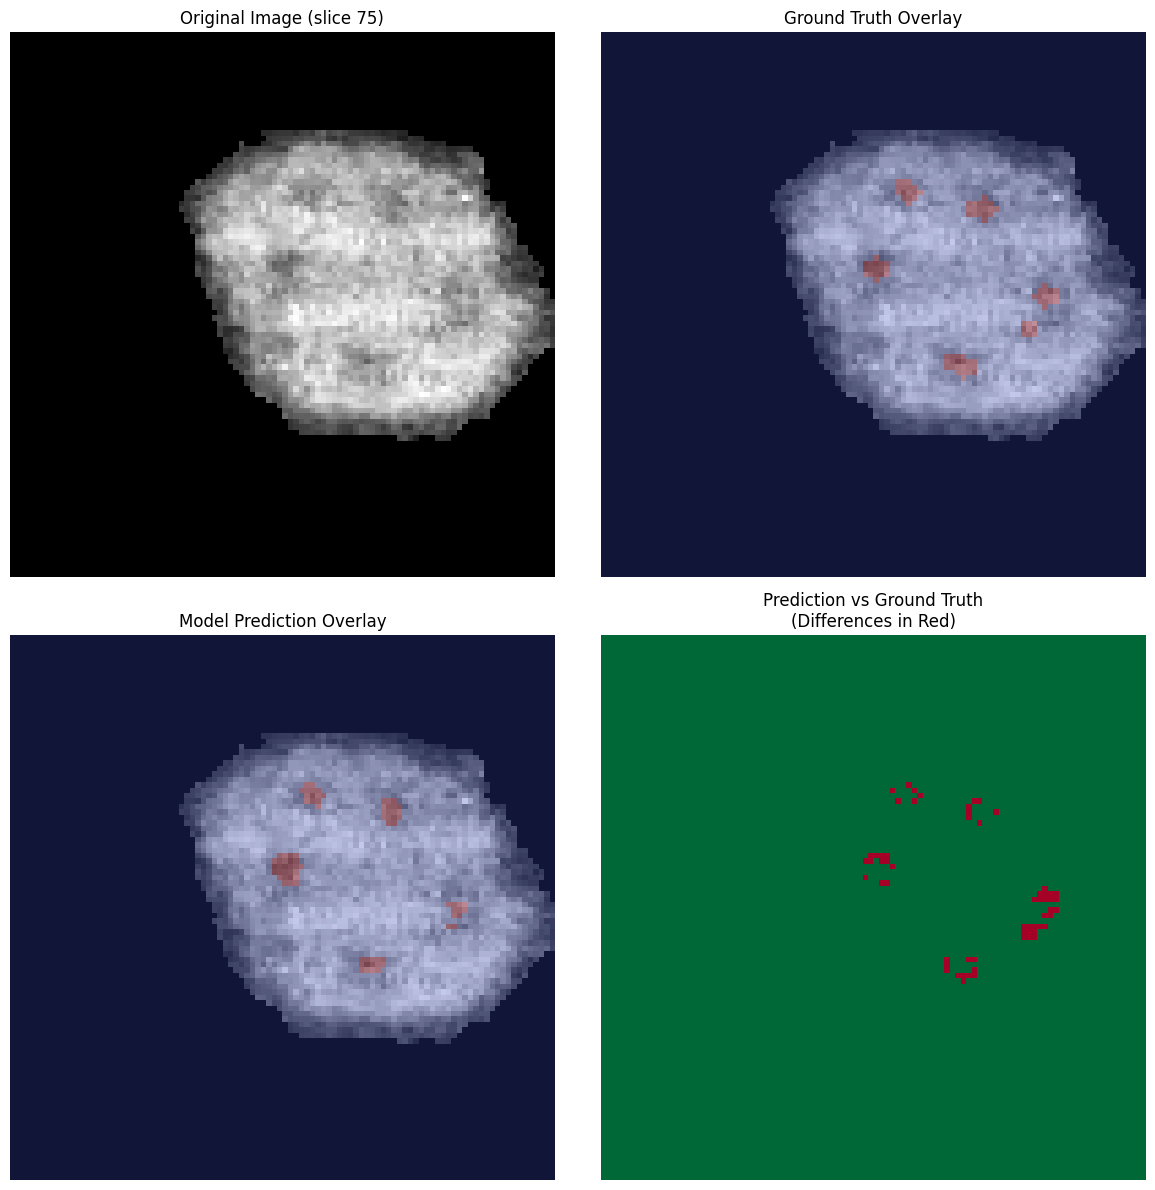


Case: 031

Slice 25:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.629


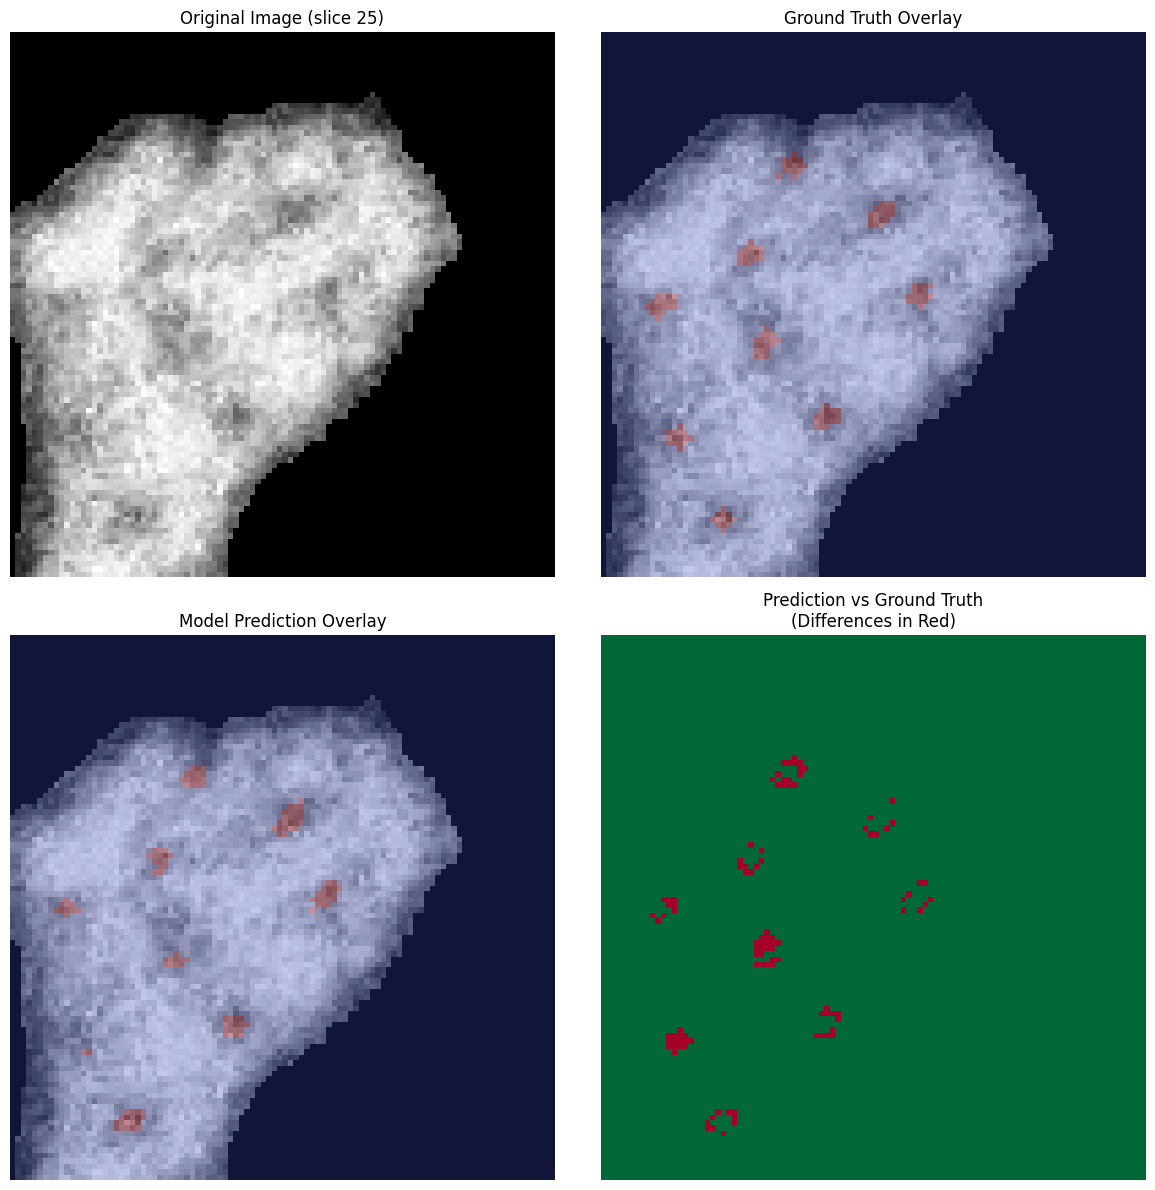


Slice 50:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.648


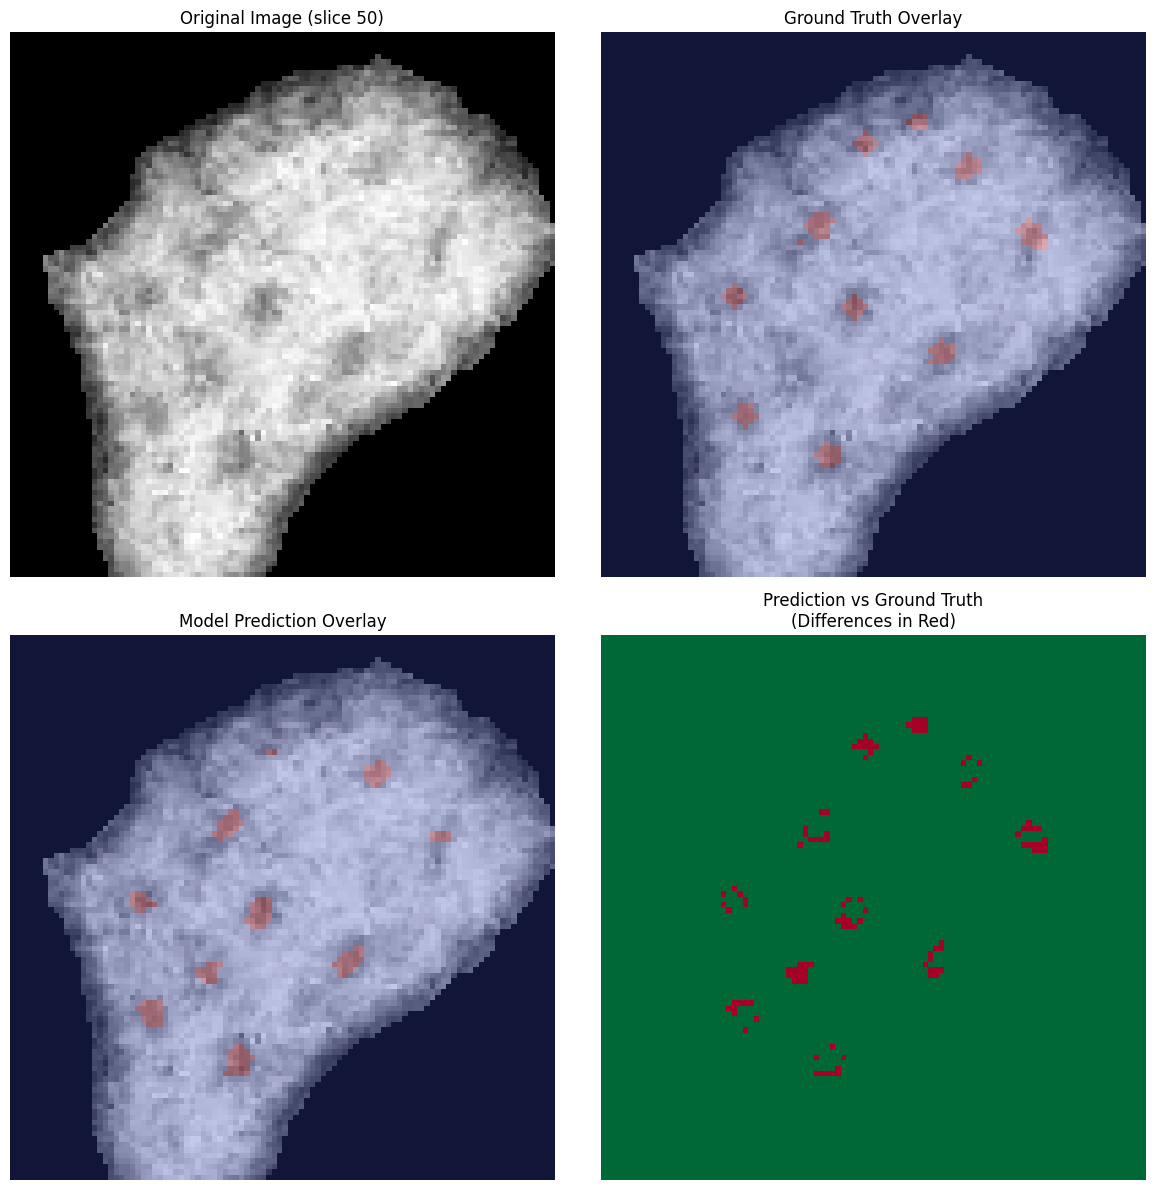


Slice 75:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.660


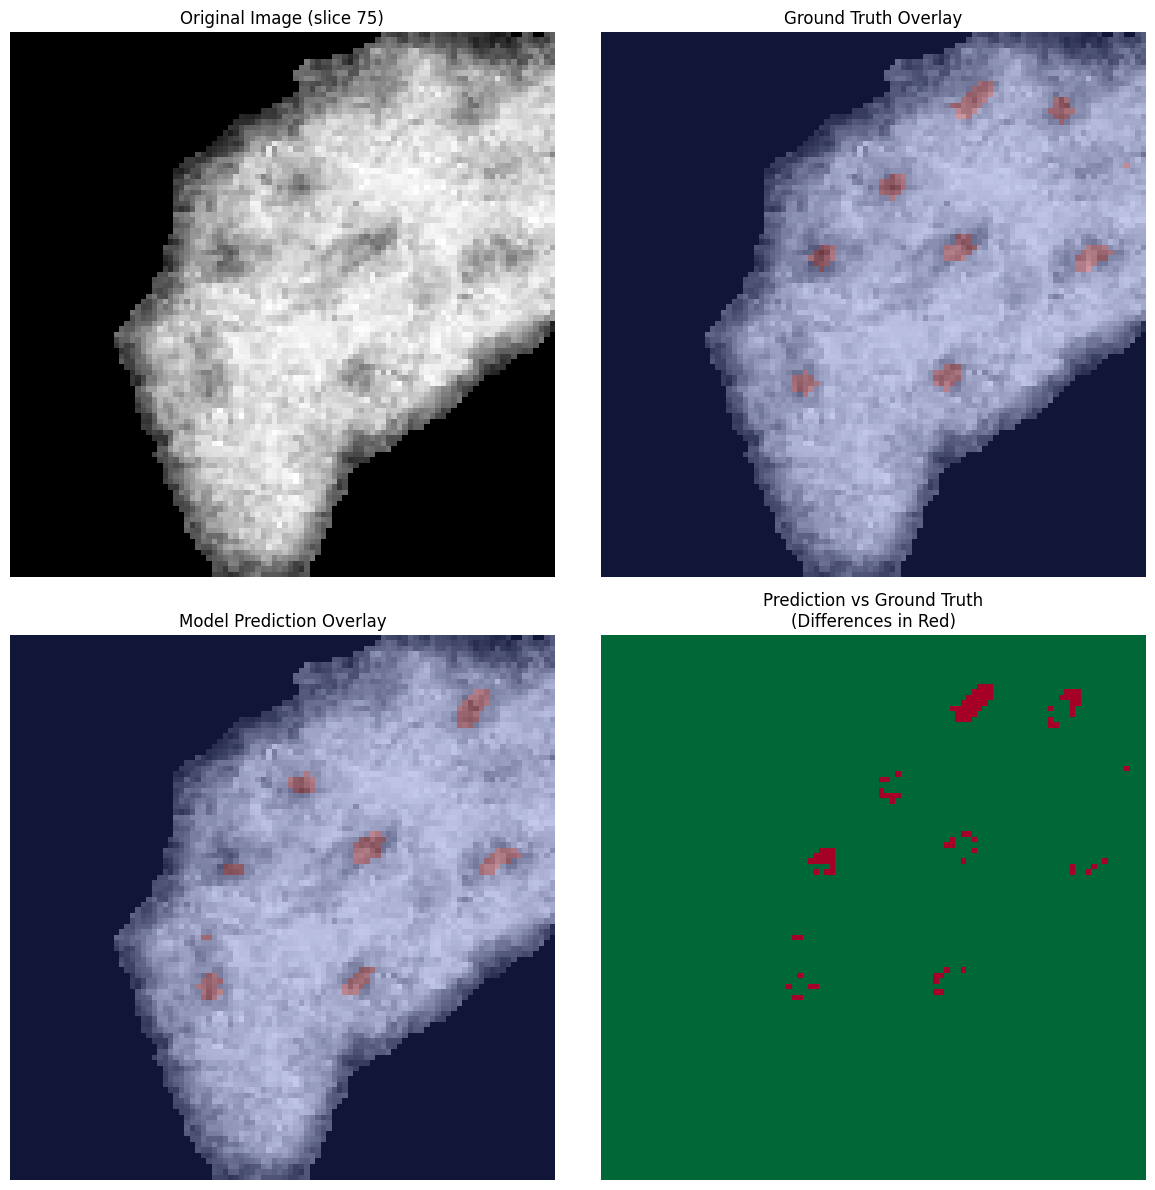


Case: 032

Slice 25:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.595


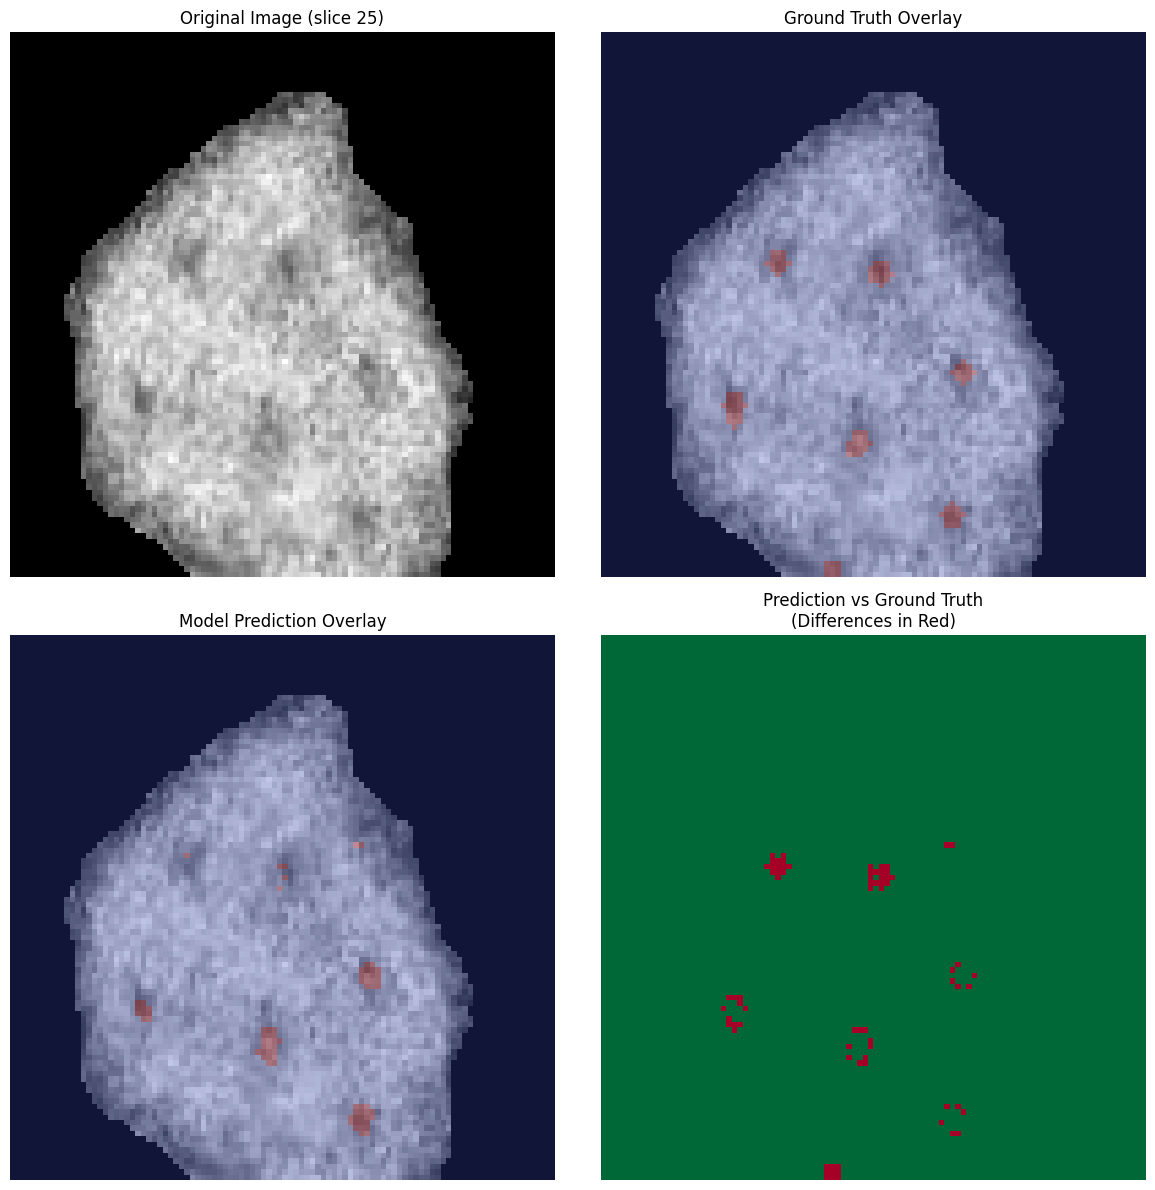


Slice 50:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.550


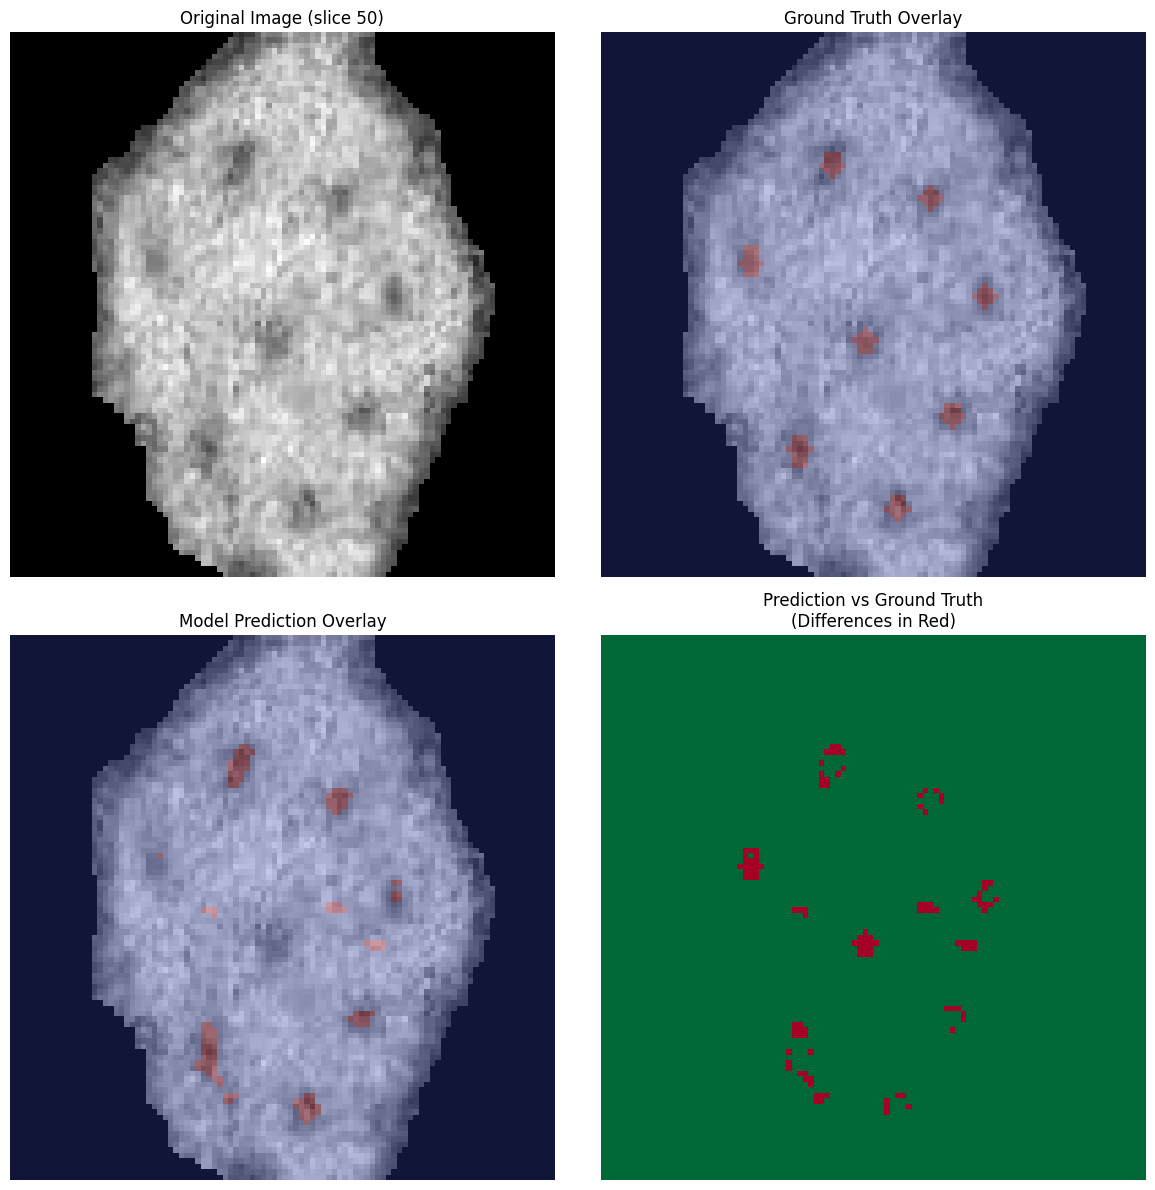


Slice 75:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.534


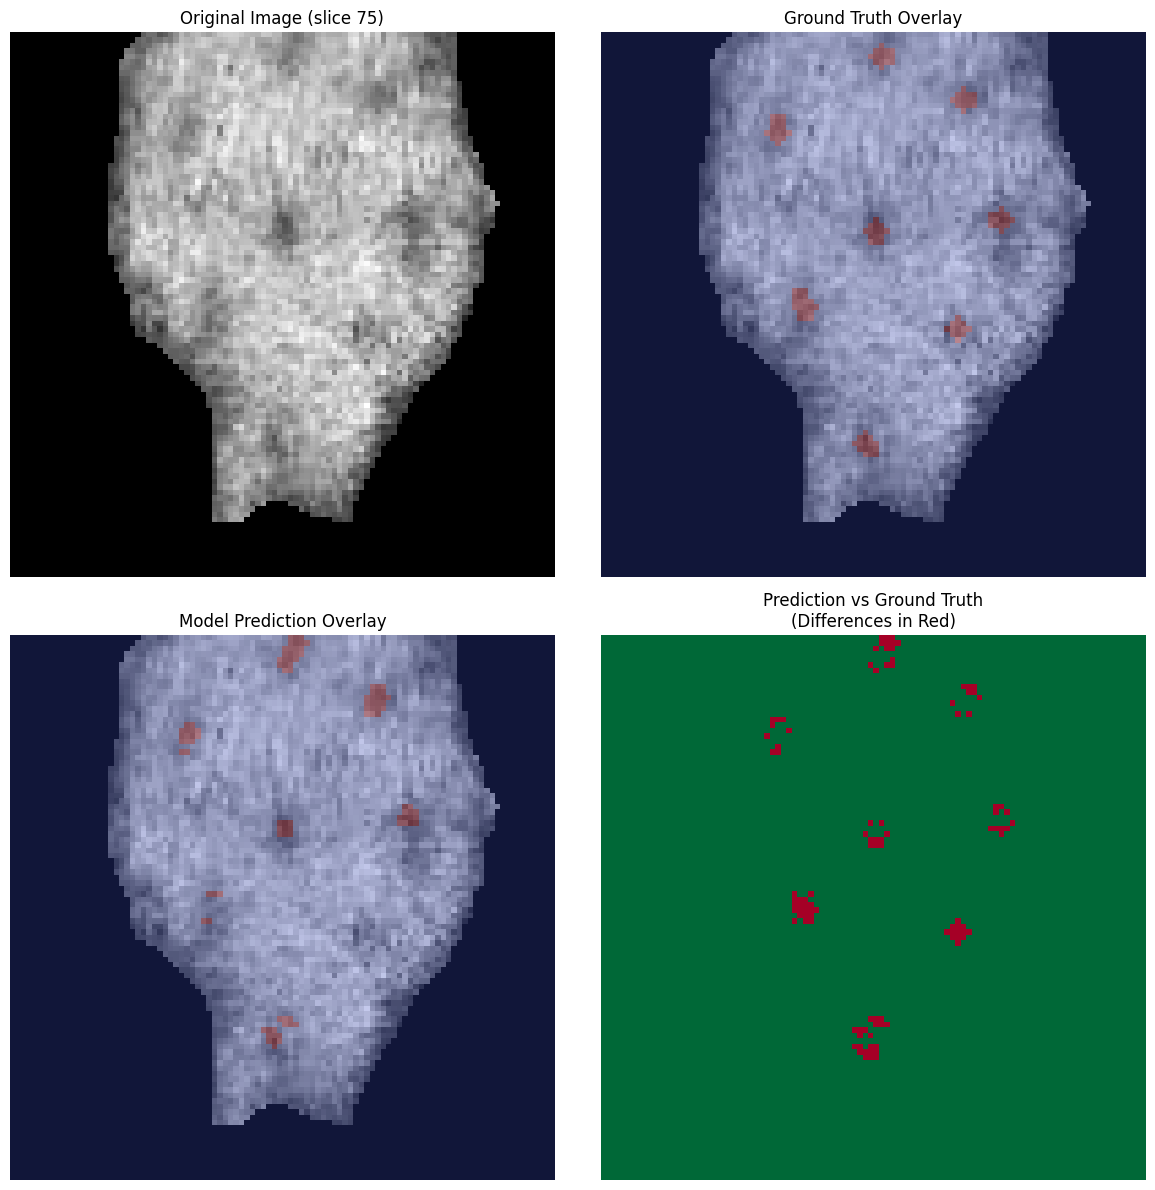


Case: 035

Slice 25:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.490


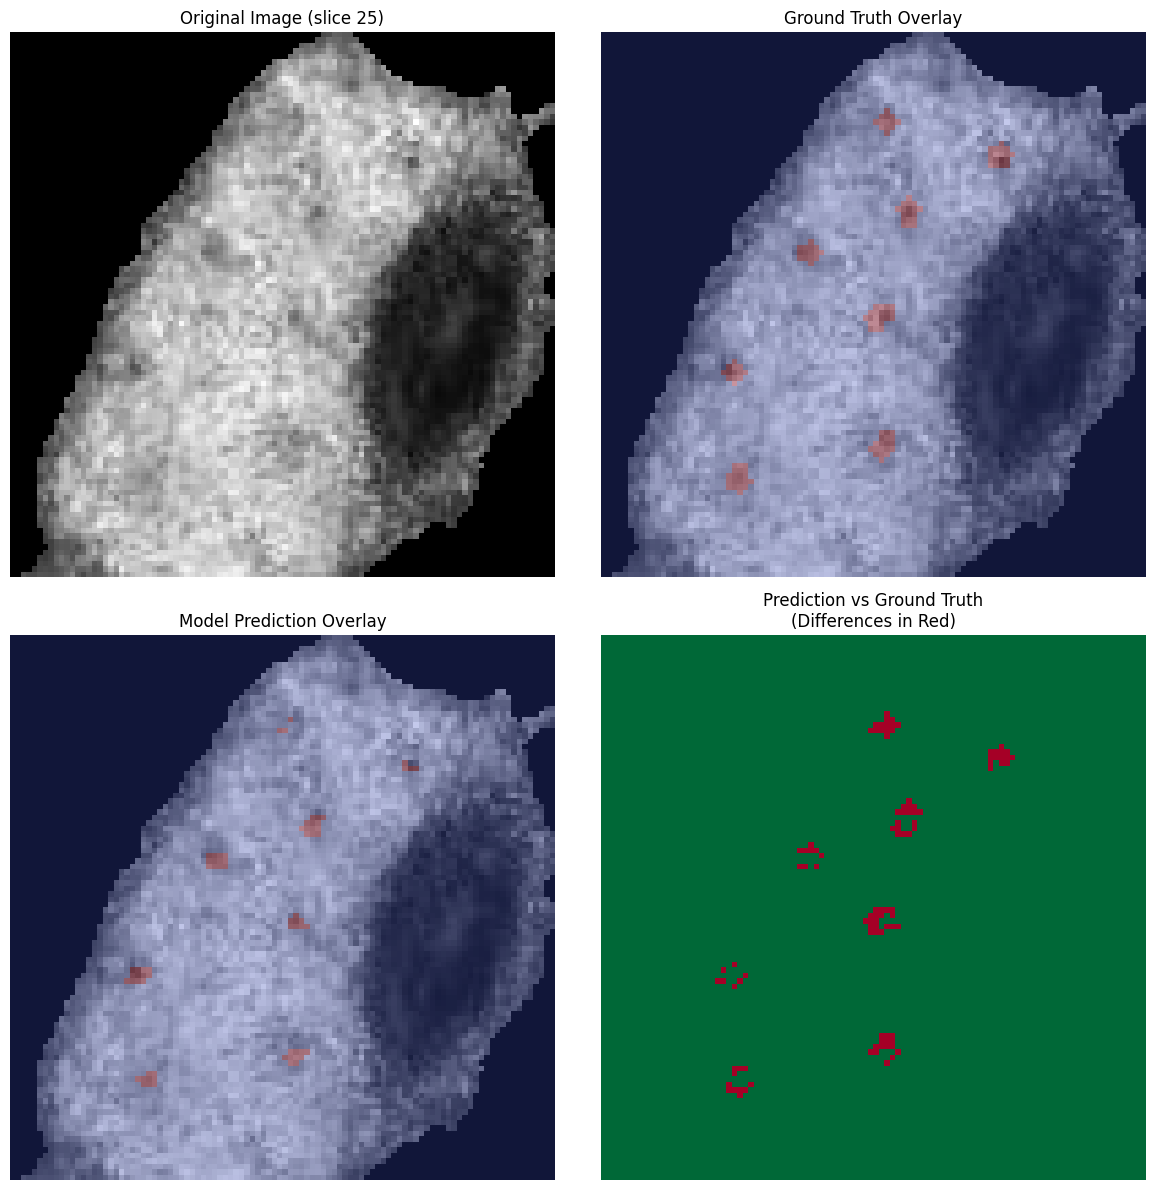


Slice 50:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.608


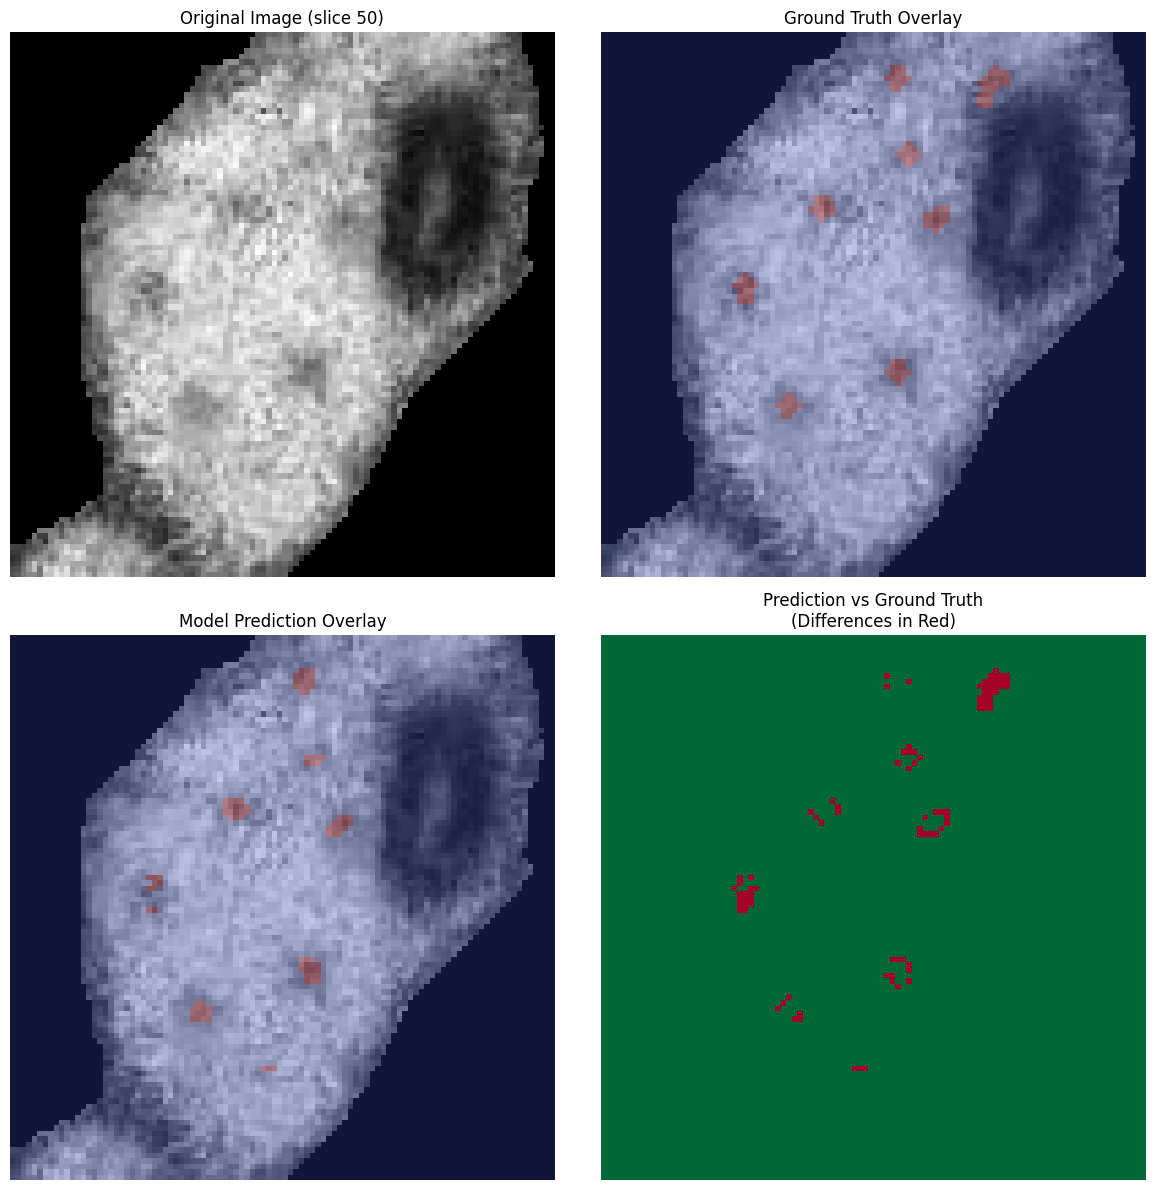


Slice 75:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.451


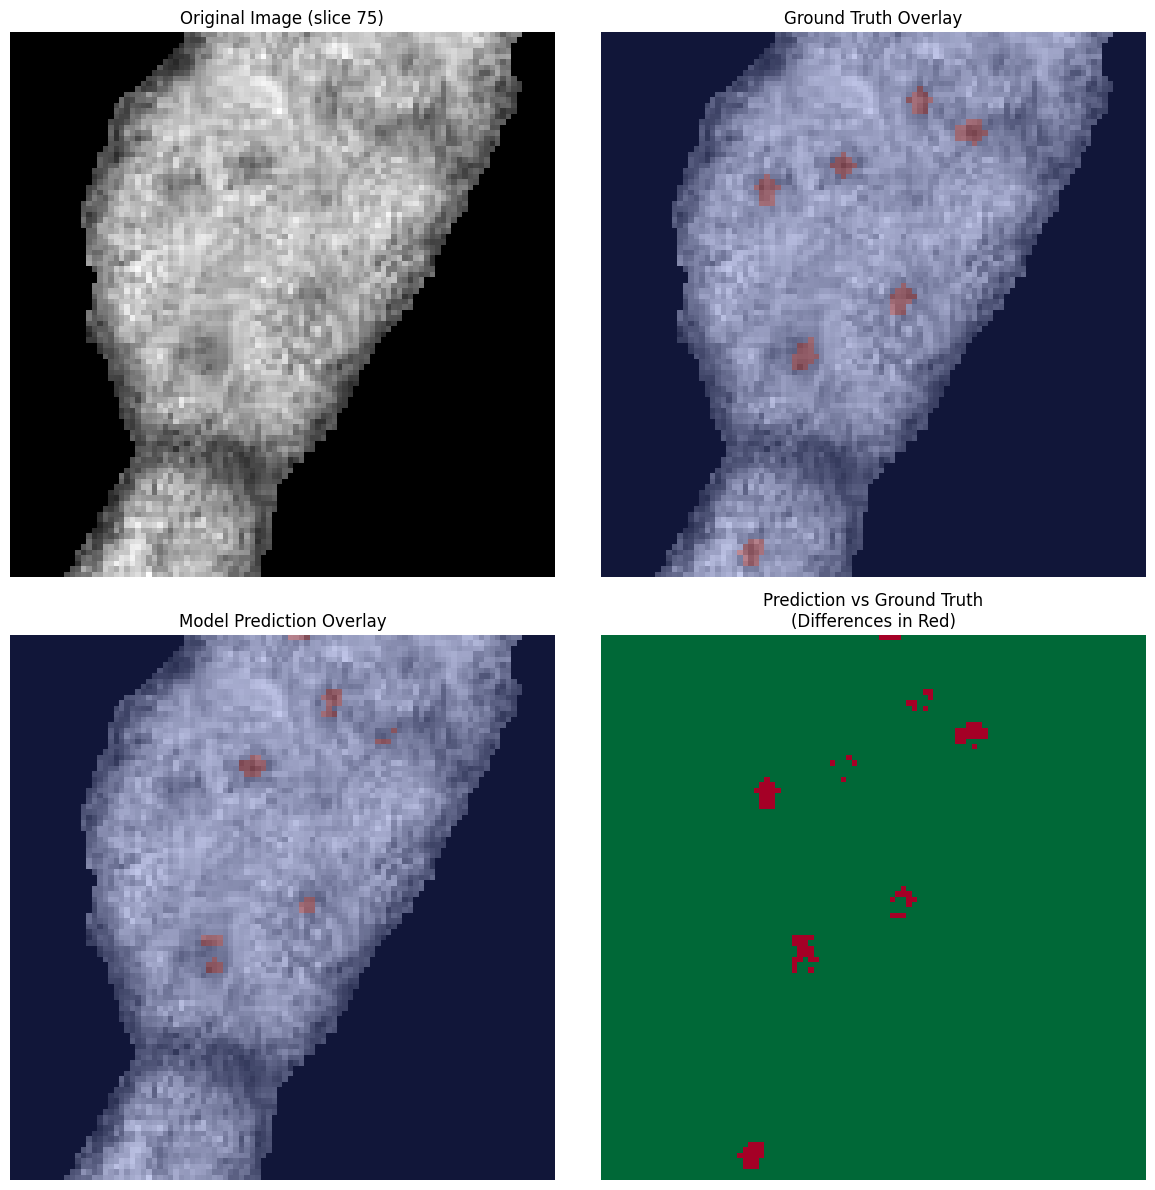


Case: 040

Slice 25:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.578


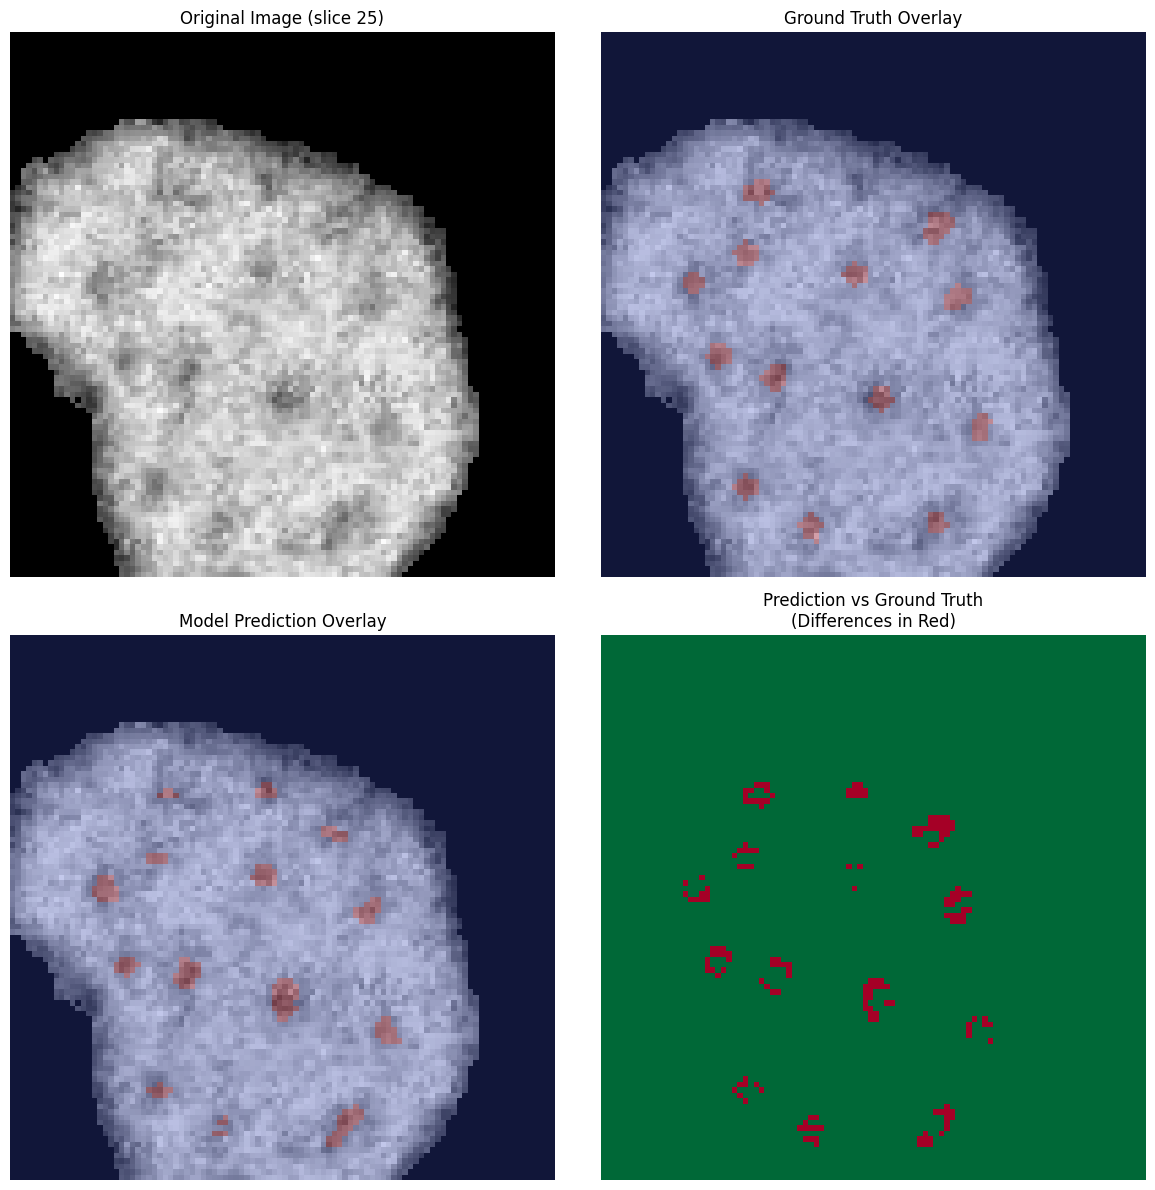


Slice 50:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.684


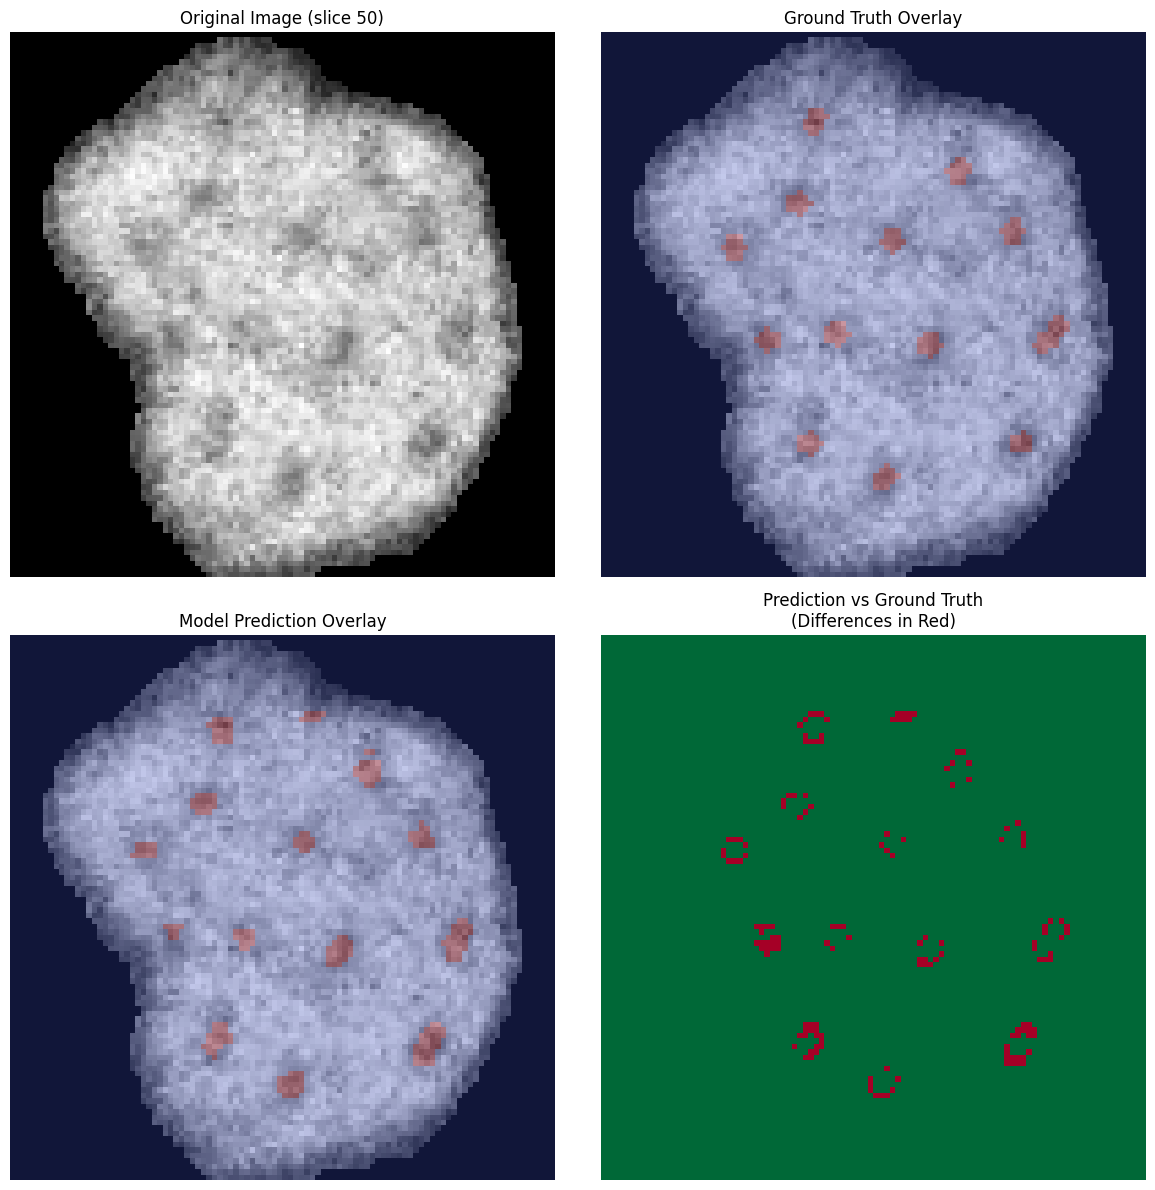


Slice 75:
Image shape: (100, 100, 100)
Image value range: [0.00, 1.00]
Label unique values: [0.         1.00000006]
Prediction unique values: [0. 1.]
Dice score for this slice: 0.646


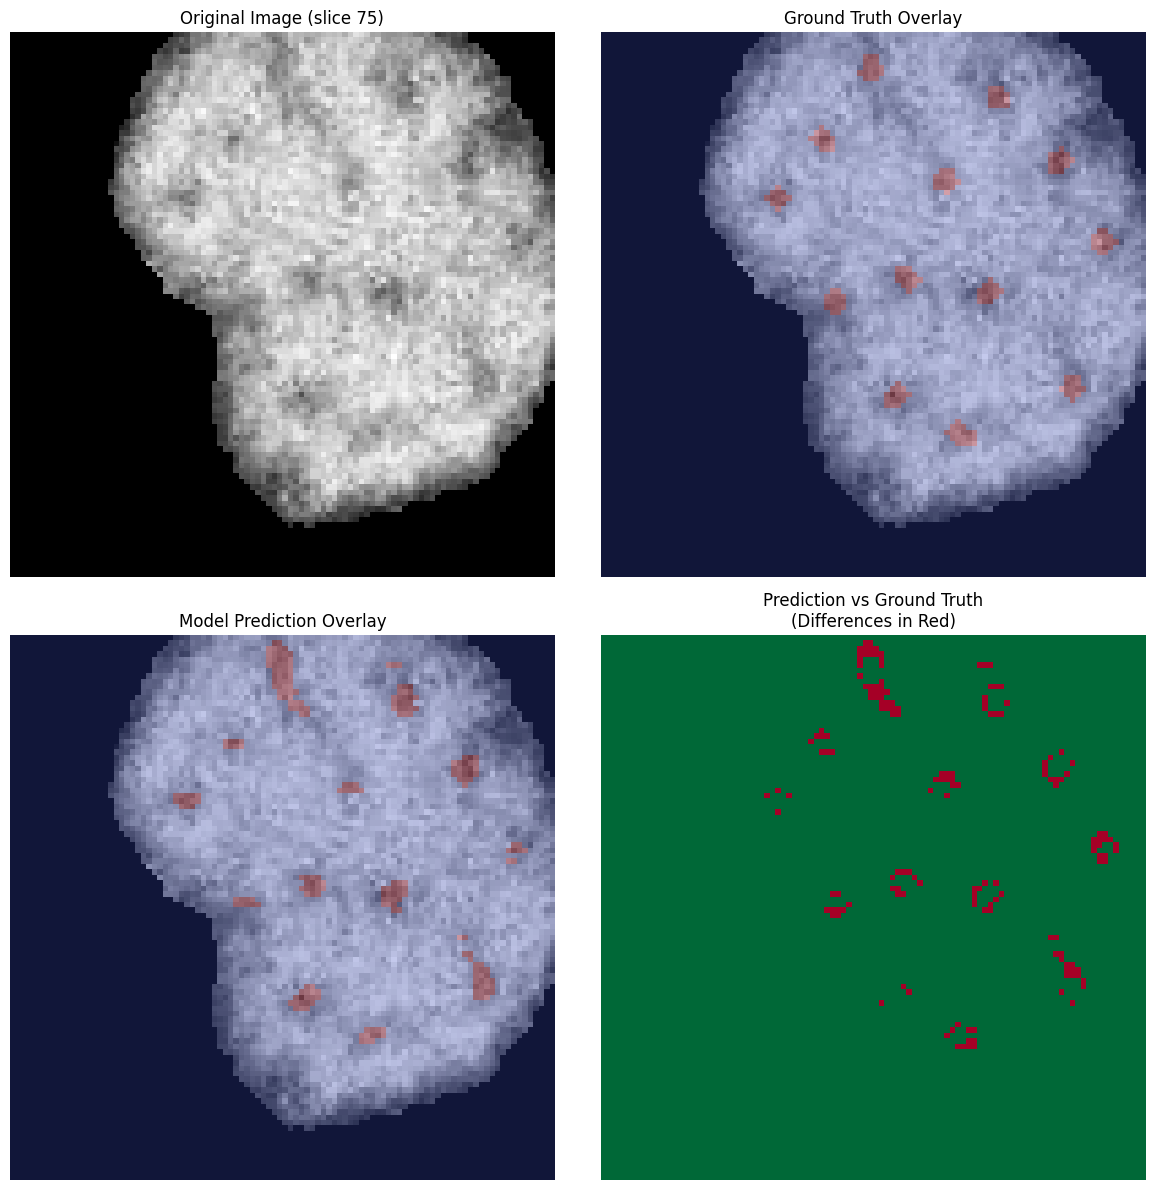

Skipping summary - missing some files

Visualization complete!


In [6]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def visualize_case_with_prediction(image_path, label_path, pred_path, slice_idx=None):
    """Visualize a single case with its label and prediction"""
    # Load the data
    image_nii = nib.load(image_path)
    label_nii = nib.load(label_path)
    pred_nii = nib.load(pred_path)
    
    image = image_nii.get_fdata()
    label = label_nii.get_fdata()
    pred = pred_nii.get_fdata()
    
    # If slice_idx not provided, use middle slice
    if slice_idx is None:
        slice_idx = image.shape[2] // 2
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    # Plot image
    axes[0,0].imshow(image[:, :, slice_idx], cmap='gray')
    axes[0,0].set_title(f'Original Image (slice {slice_idx})')
    axes[0,0].axis('off')
    
    # Plot ground truth label
    axes[0,1].imshow(image[:, :, slice_idx], cmap='gray')
    axes[0,1].imshow(label[:, :, slice_idx], cmap='coolwarm', alpha=0.3)
    axes[0,1].set_title('Ground Truth Overlay')
    axes[0,1].axis('off')
    
    # Plot prediction
    axes[1,0].imshow(image[:, :, slice_idx], cmap='gray')
    axes[1,0].imshow(pred[:, :, slice_idx], cmap='coolwarm', alpha=0.3)
    axes[1,0].set_title('Model Prediction Overlay')
    axes[1,0].axis('off')
    
    # Plot difference between prediction and ground truth
    diff = np.abs(label[:, :, slice_idx] - pred[:, :, slice_idx])
    axes[1,1].imshow(diff, cmap='RdYlGn_r')  # Red indicates differences
    axes[1,1].set_title('Prediction vs Ground Truth\n(Differences in Red)')
    axes[1,1].axis('off')
    
    plt.tight_layout()
    
    # Print statistics
    print(f"Image shape: {image.shape}")
    print(f"Image value range: [{image.min():.2f}, {image.max():.2f}]")
    print(f"Label unique values: {np.unique(label)}")
    print(f"Prediction unique values: {np.unique(pred)}")
    print(f"Dice score for this slice: {dice_score(label[:, :, slice_idx], pred[:, :, slice_idx]):.3f}")
    
    return fig

def dice_score(y_true, y_pred):
    """Calculate Dice coefficient"""
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

# Paths
dataset_dir = "/vast/palmer/home.grace/am3833/fly/segmentation/nnUNet_raw/Dataset001_Microtubules"
val_pred_dir = "/vast/palmer/home.grace/am3833/fly/segmentation/nnUNet_results/Dataset001_Microtubules/STUNetTrainer_huge_ft__nnUNetPlans__3d_fullres/fold_0/validation"

# Get list of validation cases
val_files = sorted(os.listdir(val_pred_dir))
val_identifiers = [f.split('.')[0] for f in val_files]  # Remove .nii.gz

print(f"Found {len(val_files)} validation cases: {val_identifiers}")

# Visualize validation cases
for identifier in val_identifiers:
    # Get paths
    image_path = os.path.join(dataset_dir, "imagesTr", f"{identifier}_0000.nii.gz")
    label_path = os.path.join(dataset_dir, "labelsTr", f"{identifier}.nii.gz")
    pred_path = os.path.join(val_pred_dir, f"{identifier}.nii.gz")
    
    if not all(os.path.exists(p) for p in [image_path, label_path, pred_path]):
        print(f"Skipping {identifier} - missing some files")
        continue
        
    print(f"\nCase: {identifier}")
    print("="*50)
    
    # Visualize multiple slices
    for slice_idx in [25, 50, 75]:  # View different slices
        print(f"\nSlice {slice_idx}:")
        fig = visualize_case_with_prediction(image_path, label_path, pred_path, slice_idx)
        plt.show()

print("\nVisualization complete!")